# Assignment introduction
<article class="message is-info">
  <div class="message-header">Overview</div>
  <div class="message-body">
  
  This is the first mandatory assignment in which you will implement a regression model to estimate where a person is looking (this is known as _gaze_) from images of eyes.
You only have to hand in this Jupyter Notebook containing your implementation and notes (markdown or python cells), see the bottom of this page for handin details. For the TA's to assess the assignment we kindly ask you to also hand in the `data`
 folder. If you are not comfortable sharing your data with the TA's leave that folder out for the handin, but provide the plots for assessment. Refer to the bottom of the page for submission details.
Before you start solving the assignment, carefully read through the entire assignment to get an overview of the problem and the tasks.
Notice that the optional Task 23 and onward relates to exercises in next week. You may save some time by postponing it until then.
**Note:** **Important!** Complete all tasks marked with **high (red)** priority before attempting to solve the others, as they are optional. Optional tasks and further analysis can help improve results, but feel free to explore methods and data as you choose.


  
  </div>
</article>

The assignment builds on the Data preprocessing
 exercise using the data in the `data`
 folder as well as your own. You will start with the data of `test_subject_0`
. You will then try out the model using the data from the data collection session.
The assignment is structured in the following way:
- Train gaze estimation models using data from `test_subject_0`
 training set.    - Test the models using `test_subject_0`
 test set.
    - Test the models using `test_subject_3`
.


- Train gaze estimation models using data from `test_subject_3`
, `grid`
.    - Test the models using `test_subject_3`
. 


- Train gaze estimtion models using your own data set. 

<article class="message is-primary">
  <div class="message-header">Note</div>
  <div class="message-body">
  
  The assignment has multiple steps, but the procedures will repeat. Duplicate code as needed to keep results in each cell, making it easier to review during the exam.
To simplify the assignment, most visualization and data processing code is in `iml_util.py`
. You can review it, but you're not expected to explain it. Focus on the code provided in the assignment.

  
  </div>
</article>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

**Note:** The location of the _fovea_ on the retina varies between people ($\pm$ 5 degrees). Consequently, a gaze model has to be trained (calibrated) for a specific person to be accurate. This difference is shown in [Figure 1](#kappa).

## Gaze Estimation introduction
Gaze estimation is performed by capturing images of a user's eye as shown in [Figure 2](#model) and mapping them to screen positions using a function $f_\mathbf{w}(x, y)$. Humans look at things by orienting their eyes so that the light from the point of focus hits the _Fovea_ (a point on the retina). The Fovea is not directly aligned with the center of the pupil, but at a person-specific angle, as shown in [Figure 1](#kappa). The pupil position can be used to infer gaze, but to obtain accurate gaze estimates requires training data (called calibration).


</div>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">



</div>


<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="kappa">

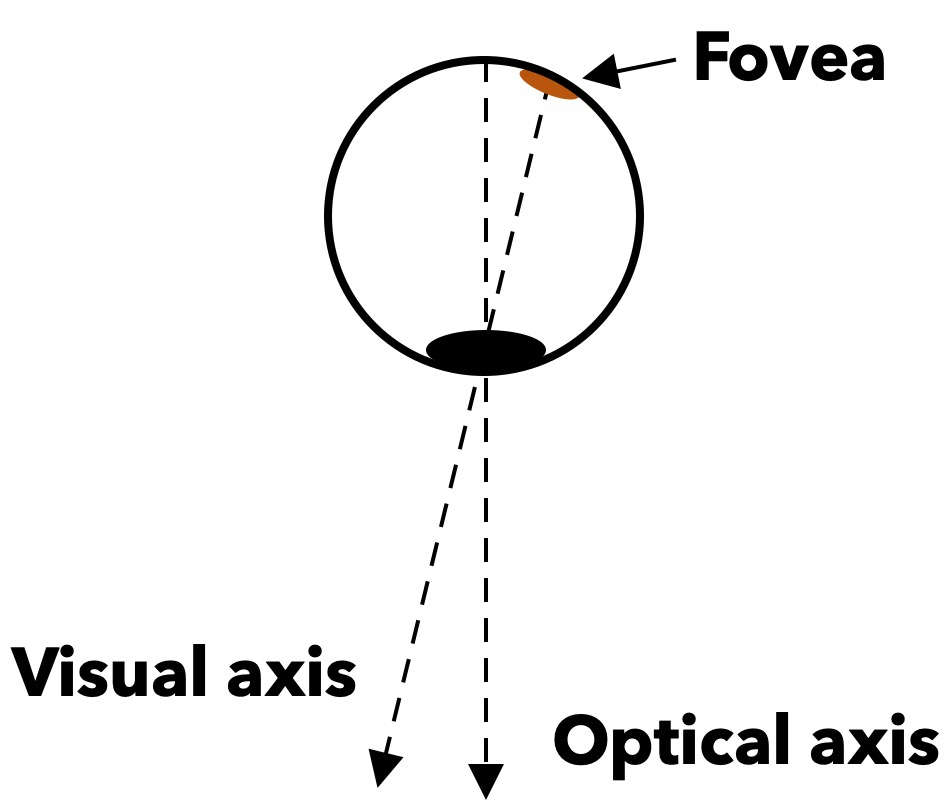

<figcaption class="figure-caption has-text-left">Figure 1: The distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis depends on the placement of the _fovea_.
</figcaption>
</figure>
</div>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="model">

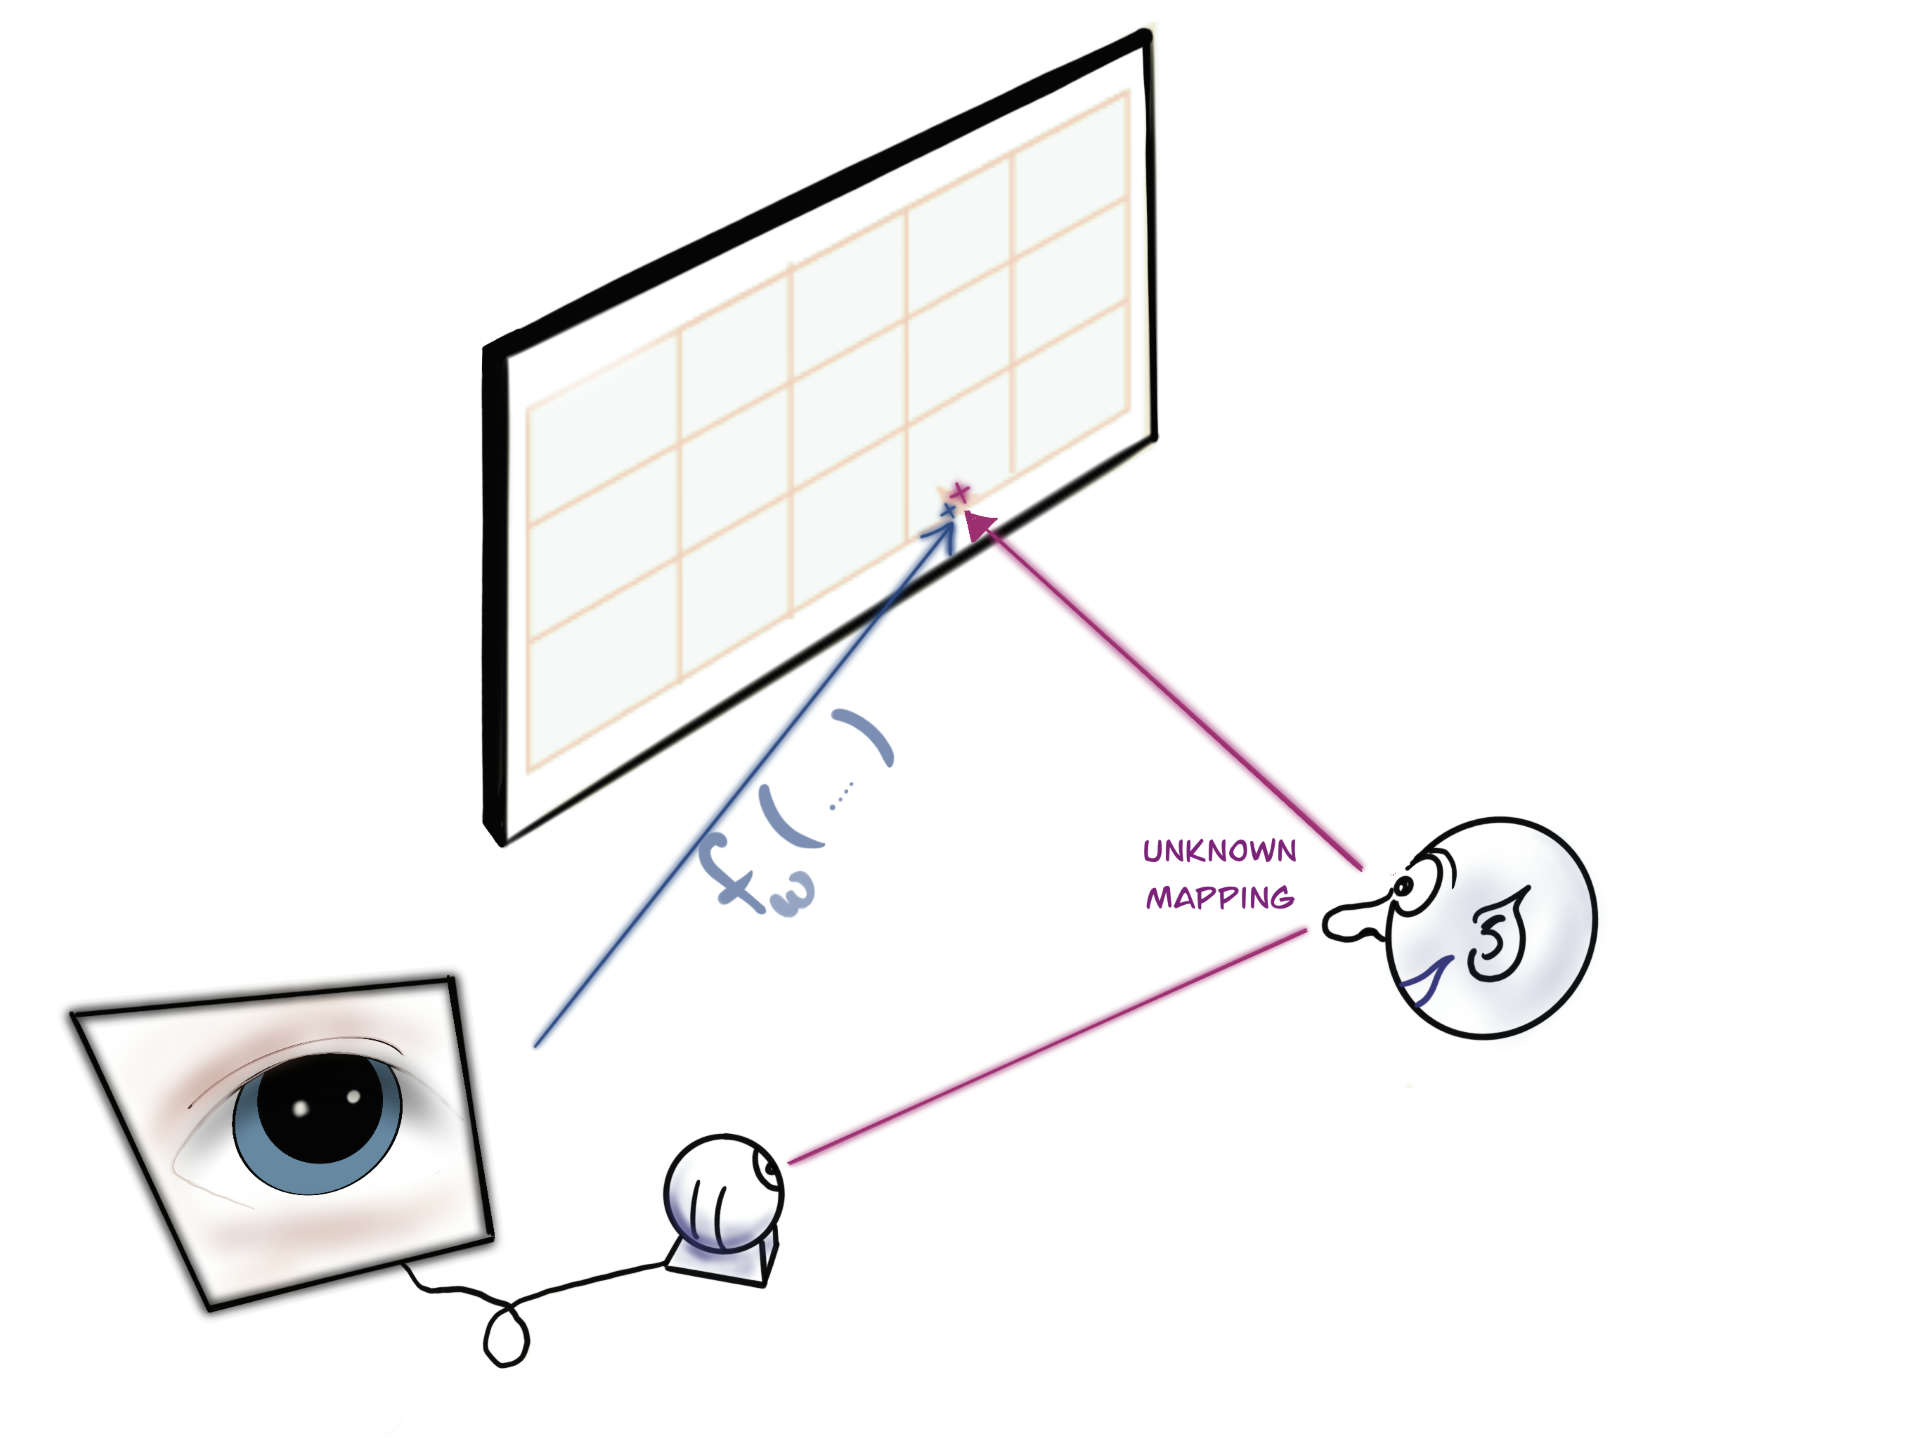

<figcaption class="figure-caption has-text-centered">Figure 2: Diagram of a gaze estimation system. The eye, which is directed at a specific point on
the screen is captured by the camera. The two red lines represent an unknown transformation from image
to eye and eye to screen. We learn this transformation directly which is shown as $f_{\mathbf{w} }(x, y)$ in the diagram.
</figcaption>
</figure>
</div>


</div>



</div>

### Gaze mapping function
The goal of this exercise is to estimate gaze from image sequences using a regression model. Define $f_{\mathbf{w}}(x, y)$ as the gaze  model which maps pupil positions $(x, y)$ to screen coordinates $(x', y')$. The model parameters $\mathbf{w}$ are learned from a training set containing paired pupil and screen positions. 
## Gaze estimation test subject 0
The first step is to train a gaze estimation model using the dataset of `test_person_0`
. You will:
- Train the models using the data `pupils_n_training`
 and `screen_coordinates_training`
. 
- Test the performance of the model using the `pupils_n_testing`
 and `screen_coordinates_testing`
. 

### Data and visualization
<article class="message task"><a class="anchor" id="task_model1"></a>
    <div class="message-header">
        <span>Task 1: Data visualization</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Inspect the structure of the dataset by revisiting exercise Data preprocessing
 section _Visualization_.
2. Run the cell below to visualize the data of `test_subject_0`
.



</div></article>



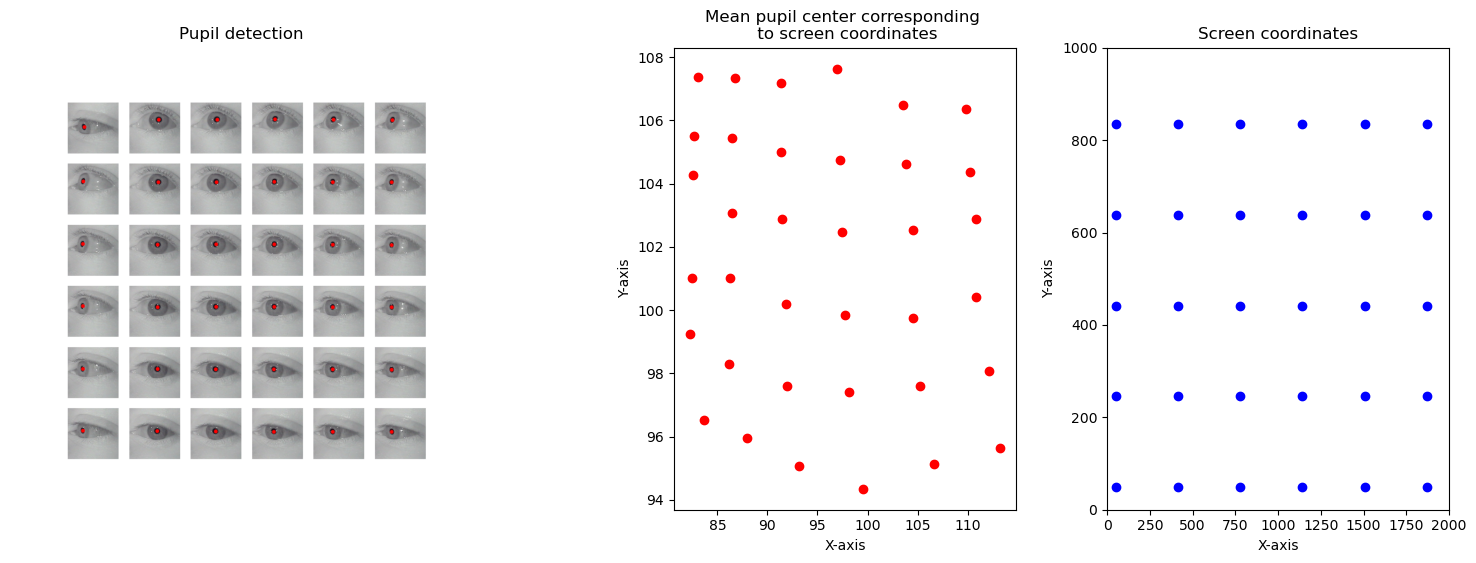

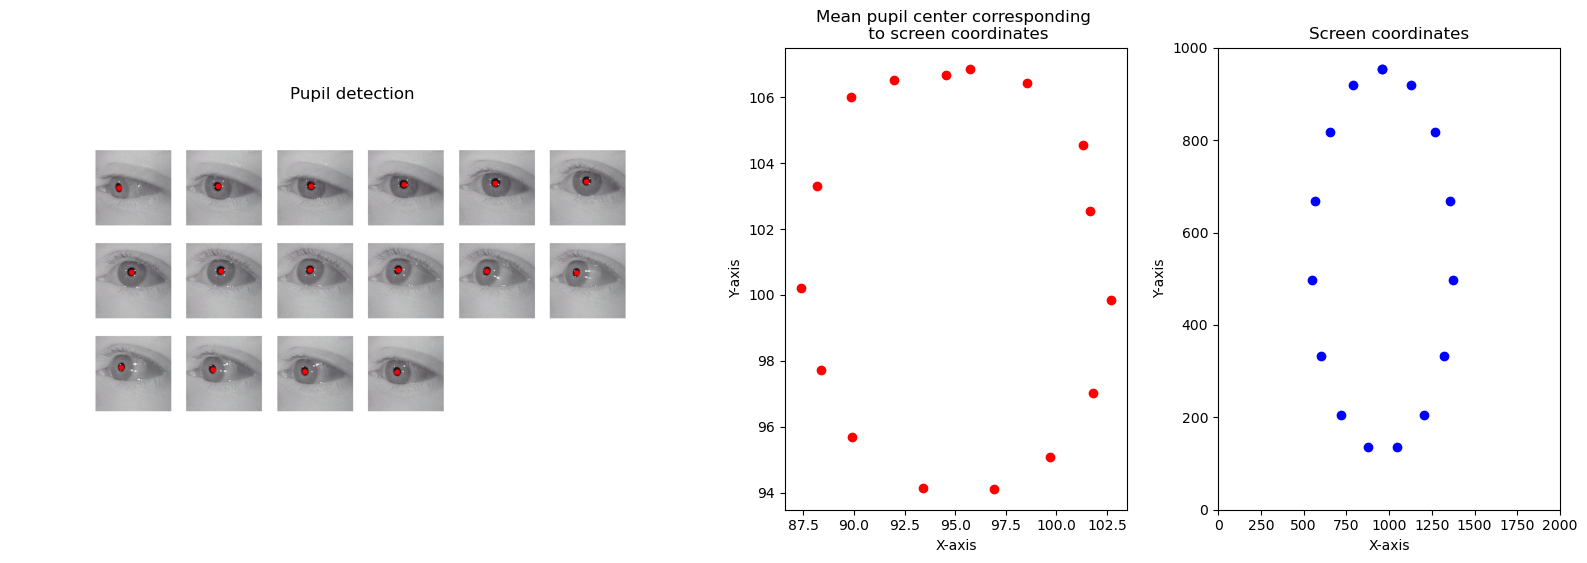

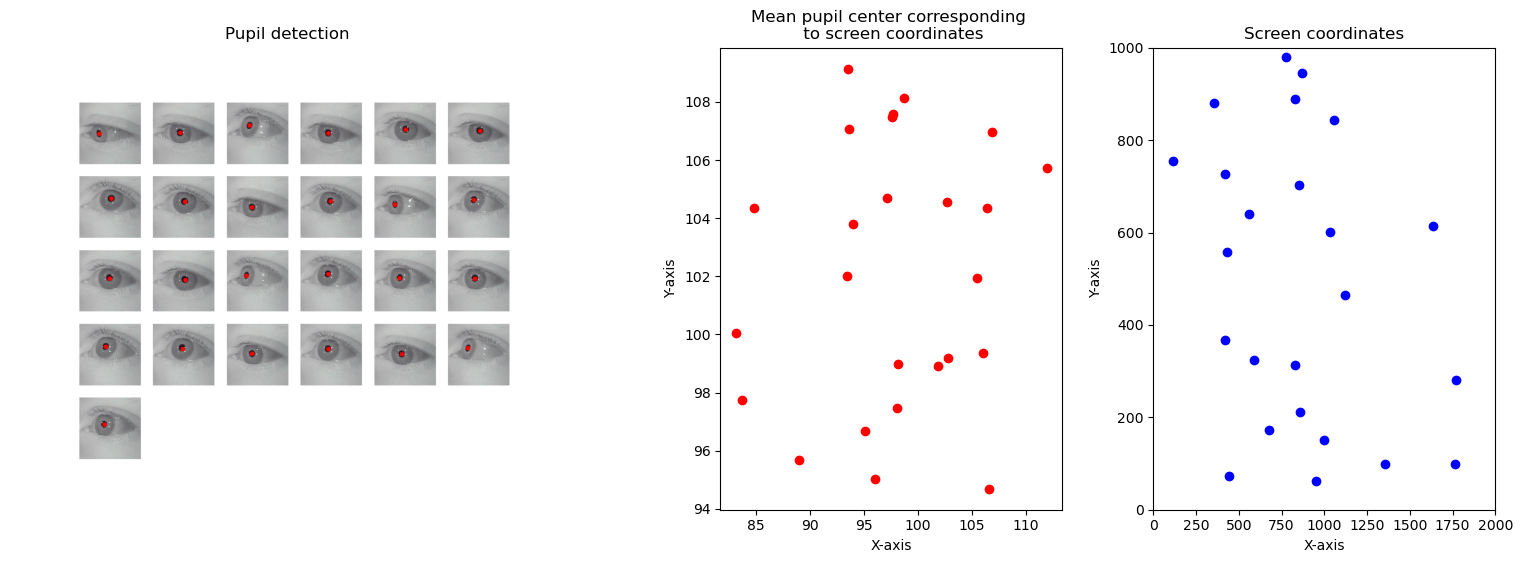

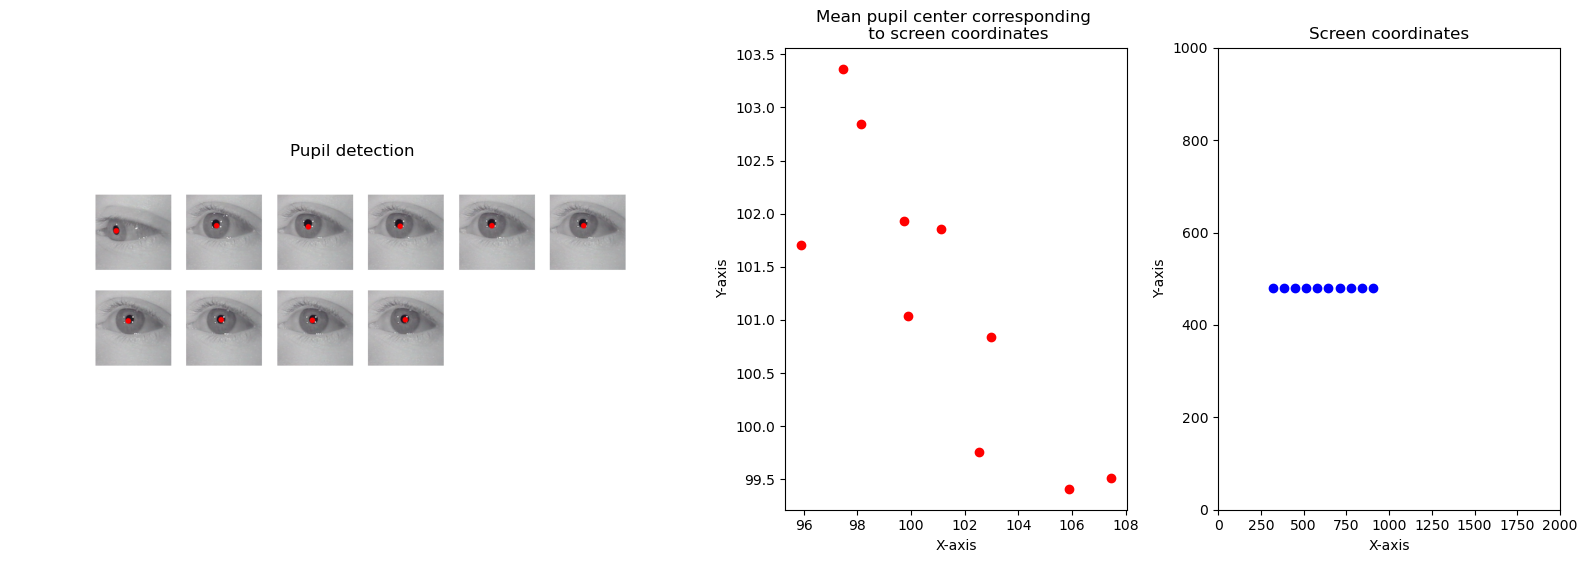

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import iml_util

D = iml_util.gen_data_subject_0()
for i in range(4):
    dataset = D[i]
    grid = iml_util.create_image_grid_viz(dataset)
    iml_util.image_and_scatter(grid, dataset)

## Implement a gaze estimation model
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: right; width: 25%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="gaze">

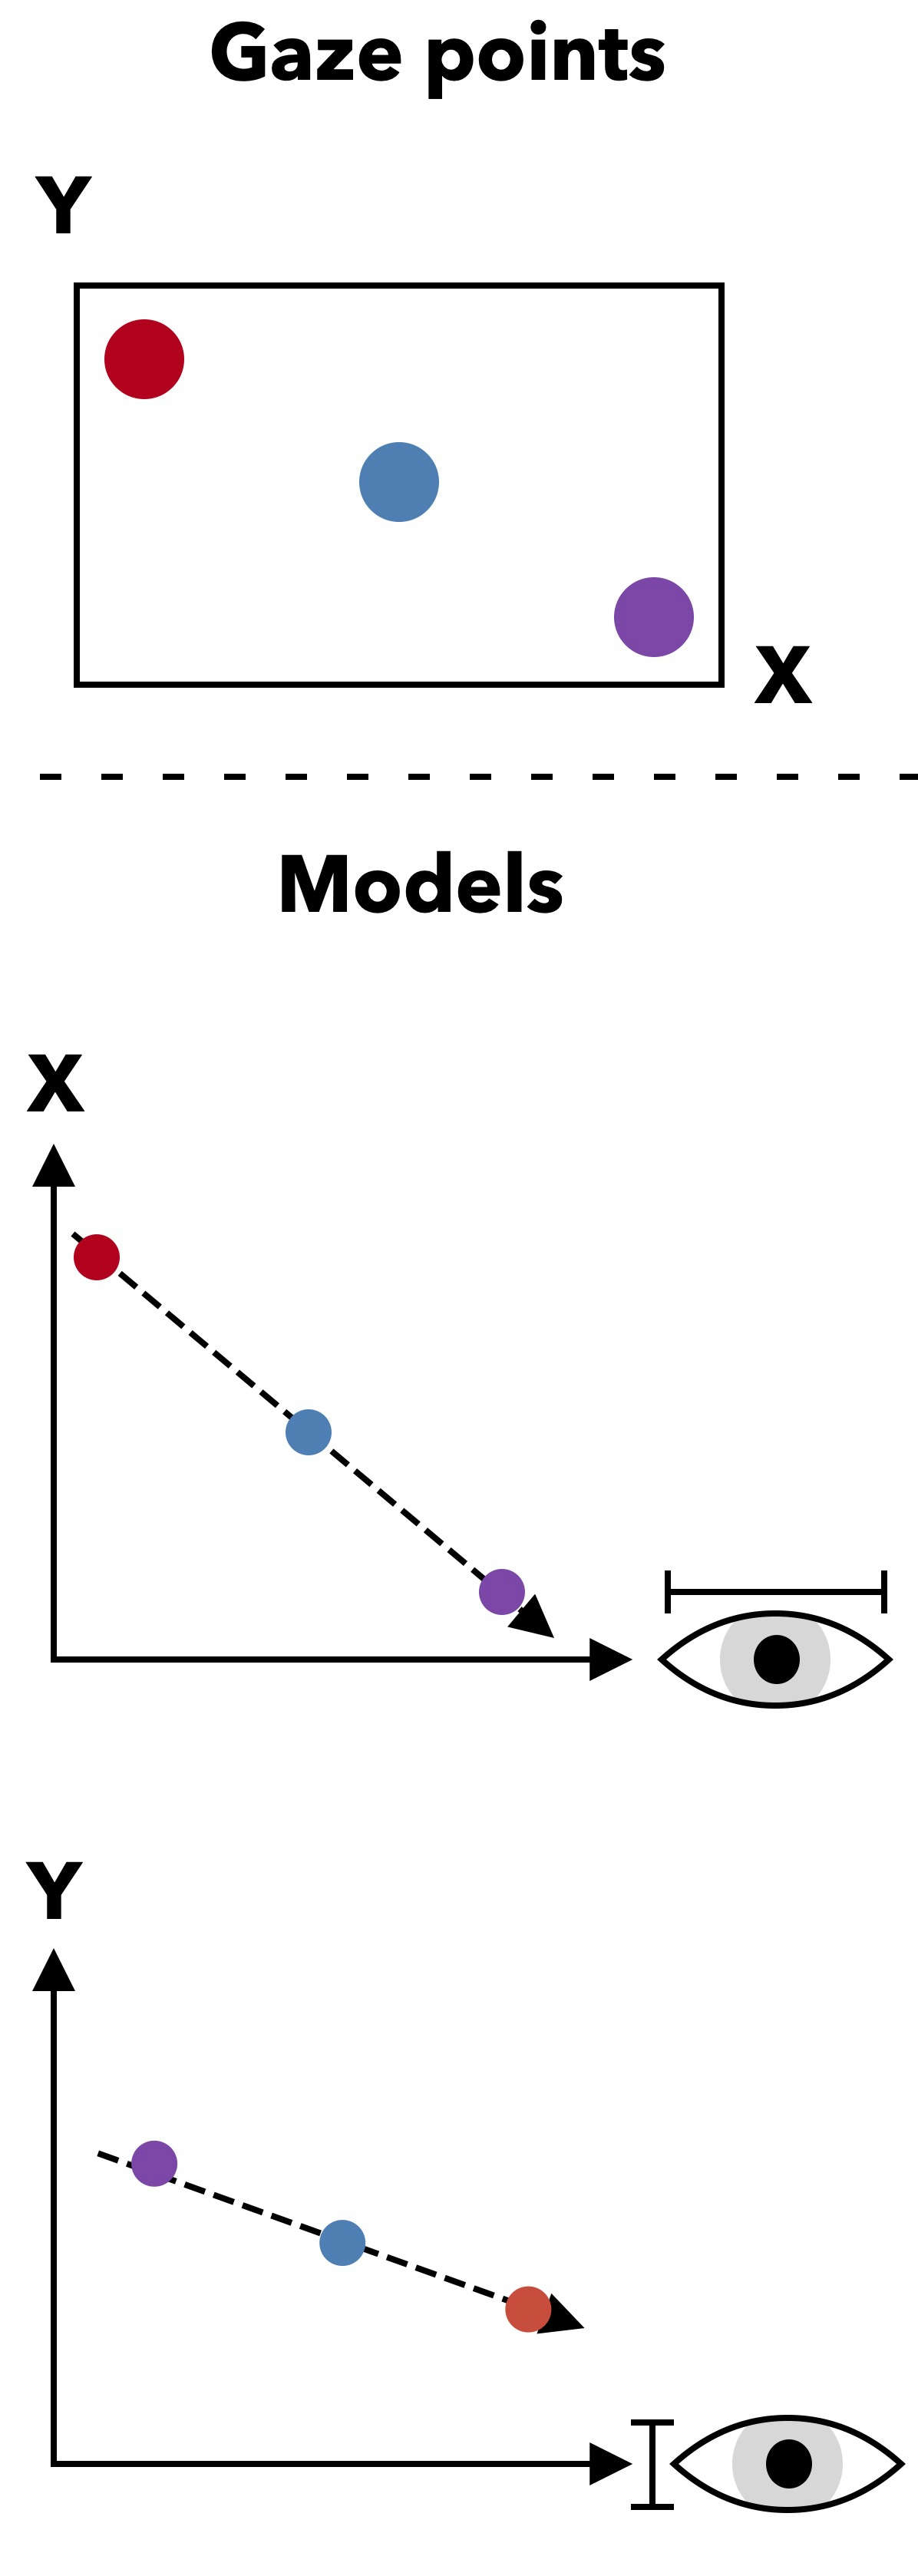

<figcaption class="figure-caption has-text-centered">Figure 3: Point mapping. Top: Three screen coordinates. Middle: Screen and eye $x$ coordinates for the same three points. Bottom: Screen and eye $y$ coordinates for the same three points.
</figcaption>
</figure>
</div>


</div>

<div style="float: left; width: 75%; justify-content: start" class="block is-clearfix">

The true nature of the function that transforms pupil positions to screen positions is not easy to model. Even when the head is stationary, the relationship between pupil position in the image and gaze is non-linear due to the pupil's movement along a spherical curve. For now, we'll approximate the gaze mapping by using a linear function. 
Since the goal is to predict a $2D$ screen coordinate from a $2D$ pupil coordinate, it's more straightforward to train two separate models for each coordinate by following the pattern of previous exercises. The linear gaze model can be expressed as:struct

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f.
\end{aligned}
$$
Gaze mappings is demonstrated in [Figure 3](#gaze) to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both models estimating the $x$ position and $y$ position on the screen.
<article class="message is-warning">
  <div class="message-header">Hint</div>
  <div class="message-body">

  Use the previous exercise
 as a guideline.


  </div>
</article>
In the upcoming tasks, you will be guided through the process of identifying essential entities necessary for establishing the linear equations required to learn the model parameters of the given model. The gaze model is divided into two distinct regression models, denoted as $x' = f_{w_1}(x, y)$ and $y' = f_{w_2}(x, y)$, each associated with its unique set of model parameters $w_1$ and $w_2$. Essentially, one model predicts the value of $x'$, and the other model predicts the value of $y'$. Follow the steps outlined below for the model $x' = f_{w_1}(x, y) = ax + by + c$, and subsequently, replicate the same steps for $y'$.
1. Identify model parameters and inputs to the model. We recommended that you use Least Squares from the numpy library [linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
, it is recommended due to numerical stability. 
2. Isolate the unknown model parameters and the known into the design matrix.
3. Setup the linear equations $Aw=b$, where $A$ is the design matrix, $w$ the unknown model parameters and $b$ contains labels.



</div>



</div>

<article class="message task"><a class="anchor" id="task_model1"></a>
    <div class="message-header">
        <span>Task 2: Initial reflection</span>
        <span class="has-text-right">
          <i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Identify the model parameters, inputs and outputs for the model.
2. Identify and determine the minimim number of data points needed to fit the model.
3. Using the least amount of points required to fit the model, does it matter which points are used? Why? Why not? 



</div></article>



In [26]:
#Write your reflection here...
""" 1. The model parameters for the linear gaze model are w1 for x' and w2 for y1.
       The inputs are (x, y) and the outputs are x' and y'.
    2. Because it is a linear model, the minimum number of datapoints needed are two
    3. The points used to fit the model do matter. Consider taking two points very close to eachother vs.
       two points far away from eachother. The results would be very different.
       (Never the less, only using two points to fit the model wouldn't give a very accurate result)

"""

" 1. The model parameters for the linear gaze model are w1 for x' and w2 for y1.\n       The inputs are (x, y) and the outputs are x' and y'.\n    2. Because it is a linear model, the minimum number of datapoints needed are two\n    3. The points used to fit the model do matter. Consider taking two points very close to eachother vs.\n       two points far away from eachother. The results would be very different.\n       (Never the less, only using two points to fit the model wouldn't give a very accurate result)\n\n"

<article class="message task"><a class="anchor" id="task_model"></a>
    <div class="message-header">
        <span>Task 3: Implement a gaze model</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


**Note:** You can choose to train two separate models, to predict each screen coordinate separately, or you can train one model predicting both coordinates simultaniously. It may be slightly simpler to use two separate models.

1. **Design matrix:** Implement a function `get_design_matrix`
 to create the design matrix from an array pupil positions.

2. **Calibration:** Complete the implementation of the function `calibrate`
 of the class `LinearGaze`
.
    - Use the `pupils_n_train`
 and `screen_coordinates_train`
 arrays as training data. 
    - Use the function `get_design_matrix`
 to create a design matrix from the pupil positions. 
    - Learn the parameters $\mathbf{w}$ from the dataset using Least Squares. 


3. **Gaze estimation:** Finish the implementation of the function `predict`
 of the class `LinearGaze`
 which predicts the gaze point given a pupil position using the learned model parameters. For reference, the affine model has the form $f_\mathbf{w}(x)=\mathbf{w}_0 x_0 + \mathbf{w}_1 x_1 + \mathbf{w}_2$. You may calculate the point for each coordinate seperately. Return the estimated screen coordinates using the models created during calibration.


**Note:** **Important!** Don't expect the affine model to perform particularly well. Expect the distances between true and predicted gaze points to vary by $\pm 200$ pixels.



</div></article>



In [27]:
def get_design_matrix(pupil_positions):
    """
    Constructs a design matrix.
    Parameters:
    pupil_positions (N x 2 numpy array): n samples, 2 features (px, py).

    Returns:
    design_matrix (N x 3 numpy array) : n_samples, 2 features + 1
    """
    ones = np.ones((pupil_positions.shape[0], 1))
    design = np.hstack((ones, pupil_positions))
    return design
    # Write your implementation

def linear(param, x):
    return param[0] + param[1]*x[0] + param[2]*x[1]

class GazeModel:
    def calibrate(self, dataset):
        ...

    def predict(self, pupil):
        ...

    def predict_many(self, pupils):
        return np.array([self.predict(pupil) for pupil in pupils])


class LinearGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the LinearGaze model by fitting two linear regression models for x and y coordinates based
        on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data with two keys:
                - "pupils_train" (N x 2 numpy array): n samples, 2 features (px, py) representing pupil
                  positions.
                - "positions_train" (N x 2 numpy array): n samples, 2 features (screen coordinate x, screen coordinates y) representing
                  the true gaze positions being the screen coordinates.

        Returns:
            None: Updates the model's parameters (self.model_x, self.model_y) based on
            the least squares solution for x and y positions.
        """
        # Write your implementation
        design = get_design_matrix(pupil_training_set)
        x_coords = screen_training_set[:, 0]
        y_coords = screen_training_set[:, 1]
        self.model_x = np.linalg.lstsq(design, x_coords)[0] # this is least squares
        self.model_y = np.linalg.lstsq(design, y_coords)[0]




    def predict(self, pupil):
        """
        Predicts the gaze position (x, y) based on the given pupil position using the calibrated model.

        Parameters:
            pupil (1 x 2 numpy array): 2 features (px, py) representing the current pupil position.

        Returns:
            x, y (float, float): Predicted gaze position (x, y) based on the linear model.
        """
        # Write your implementation
        x = self.model_x @ np.append(1, pupil)
        y = self.model_y @ np.append(1, pupil)
        return (x, y)

# LinearGaze.calibrate(D[0], D[0]["pupils_n_train"], D[0]["screen_coordinates_n_train"])

<article class="message task"><a class="anchor" id="evaluation"></a>
    <div class="message-header">
        <span>Task 4: Model evaluation</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


The following task is about evaluating the performance of your models. In the following task you will complete the function `results_for_model`
. It is important that the results are calculated for the complete dataset of `test_subject_0`
 (all of $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ as one dataset).
1. Finish the implementation of the function `results_for_model`
. For each dataset it must:    - **Calculate prediction errors:**         - Calculate:            - The _absolute error_ between each prediction and true gaze.
            - The _mean Eucledian distance_ between the true values and the predictions.
            - The _root-mean-square error_ (_rmse_) between the true values and the predictions.
            - The _mean absolute error_ (_mae_) as well.









</div></article>



In [28]:
def results_for_model(model, dataset_train, dataset_test, pupil_training_set, screen_training_set, pupil_test_set, screen_test_set, d_max):
    """
    Evaluates the performance of the model across multiple datasets and computes prediction errors.

    Parameters:
        model (object): A gaze model object.
        d_max (int, optional): Maximum number of patterns of a dataset to evaluate. Default is 4.

    Returns:
        results (dict): A dictionary where each key corresponds to a dataset index (0 to d_max-1), and each value is a dictionary containing:
            - "errors" (N x 2 numpy array): Absolute errors between predicted and ground truth positions (x, y).
            - "rmse" (float): Root Mean Squared Error (RMSE) for the predictions across the dataset.
            - "dist" (float): Mean Euclidean distance between the predicted and actual positions.
            - "mae" (1 x 2 numpy array): Mean absolute error in x and y dimensions.
    """

    results = {}
    for d in range(d_max):
        train = dataset_train[d]
        test = dataset_test[d]
        model.calibrate(train, train[pupil_training_set], train[screen_training_set])
        predicted = model.predict_many(test[pupil_test_set])
        ground_truth = test[screen_test_set]

        errors = np.abs(predicted - ground_truth)
        rmse = np.sqrt(np.mean(errors**2))
        dist = np.mean(np.linalg.norm(errors, axis=1))
        mae = np.mean(errors, axis=0)

        results[d] = {
            "errors": errors,
            "rmse": rmse,
            "dist": dist,
            "mae": mae,
            "predicted": predicted,
            "ground_truth": ground_truth,
            "model_x": model.model_x,
            "model_y": model.model_y
        }

    return results

results_linear = results_for_model(LinearGaze(), D, D, 'pupils_n_train', 'screen_coordinates_train', 'pupils_n_test', 'screen_coordinates_test', 4)
print(f"errors: {results_linear[0].get('errors')}")
print(f"RMSE: {results_linear[0].get('rmse')}")
print(f"euclidian distance: {results_linear[0].get('dist')}")
print(f"mae distance: {results_linear[0].get('mae')}")
print(f"predicted: {results_linear[0].get('predicted')}")

errors: [[ 73.548127    85.38869146]
 [  0.64899243  21.81978418]
 [ 95.77909325  62.80039592]
 [144.78879676  35.89908041]
 [119.4672585    8.40664317]
 [ 36.17484246  32.6758081 ]
 [  0.59240852  63.31574191]
 [ 79.95502979   2.47357254]
 [184.45435512  41.92422502]
 [223.80377169  51.10687492]
 [230.86500561  24.16698597]
 [124.06675792  28.38536162]
 [ 77.64397332  33.62186861]
 [122.76139112  39.93192504]
 [205.91827032  59.60942834]
 [223.72636738  57.96131007]
 [221.80024299  20.46979936]
 [105.14533579  35.18845877]
 [ 70.61363568  18.8602821 ]
 [120.28270218  31.67667   ]
 [219.6521497   65.04968201]
 [240.32062193  59.00737917]
 [203.50706513  66.92318164]
 [ 91.68254665   6.99717031]
 [107.6841224   70.36523989]
 [162.1564003   78.80961363]
 [225.22145425  96.808124  ]
 [247.69817172 100.52302405]
 [197.44564383  88.54570767]
 [ 81.6224806   97.92938583]
 [133.27888353 124.26581457]
 [178.33903723 139.43476097]
 [242.91004269  82.31728091]
 [241.0171099  138.46965422]
 [175.

Below you find a cell containing a function for visualizing the performance of the model. 
<article class="message task"><a class="anchor" id="evaluation1"></a>
    <div class="message-header">
        <span>Task 5: Visualize performance of your model</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. **Create visualizations:** Run the cell below to visualiz the performance of the model for all patterns using the function `plot_results_grid`
 from `iml_util.py`
. The function takes a dictionary of results as well as the number of patterns in the dictionary. Combined they provide an overview of the nature of the error across the two dimensions.



</div></article>



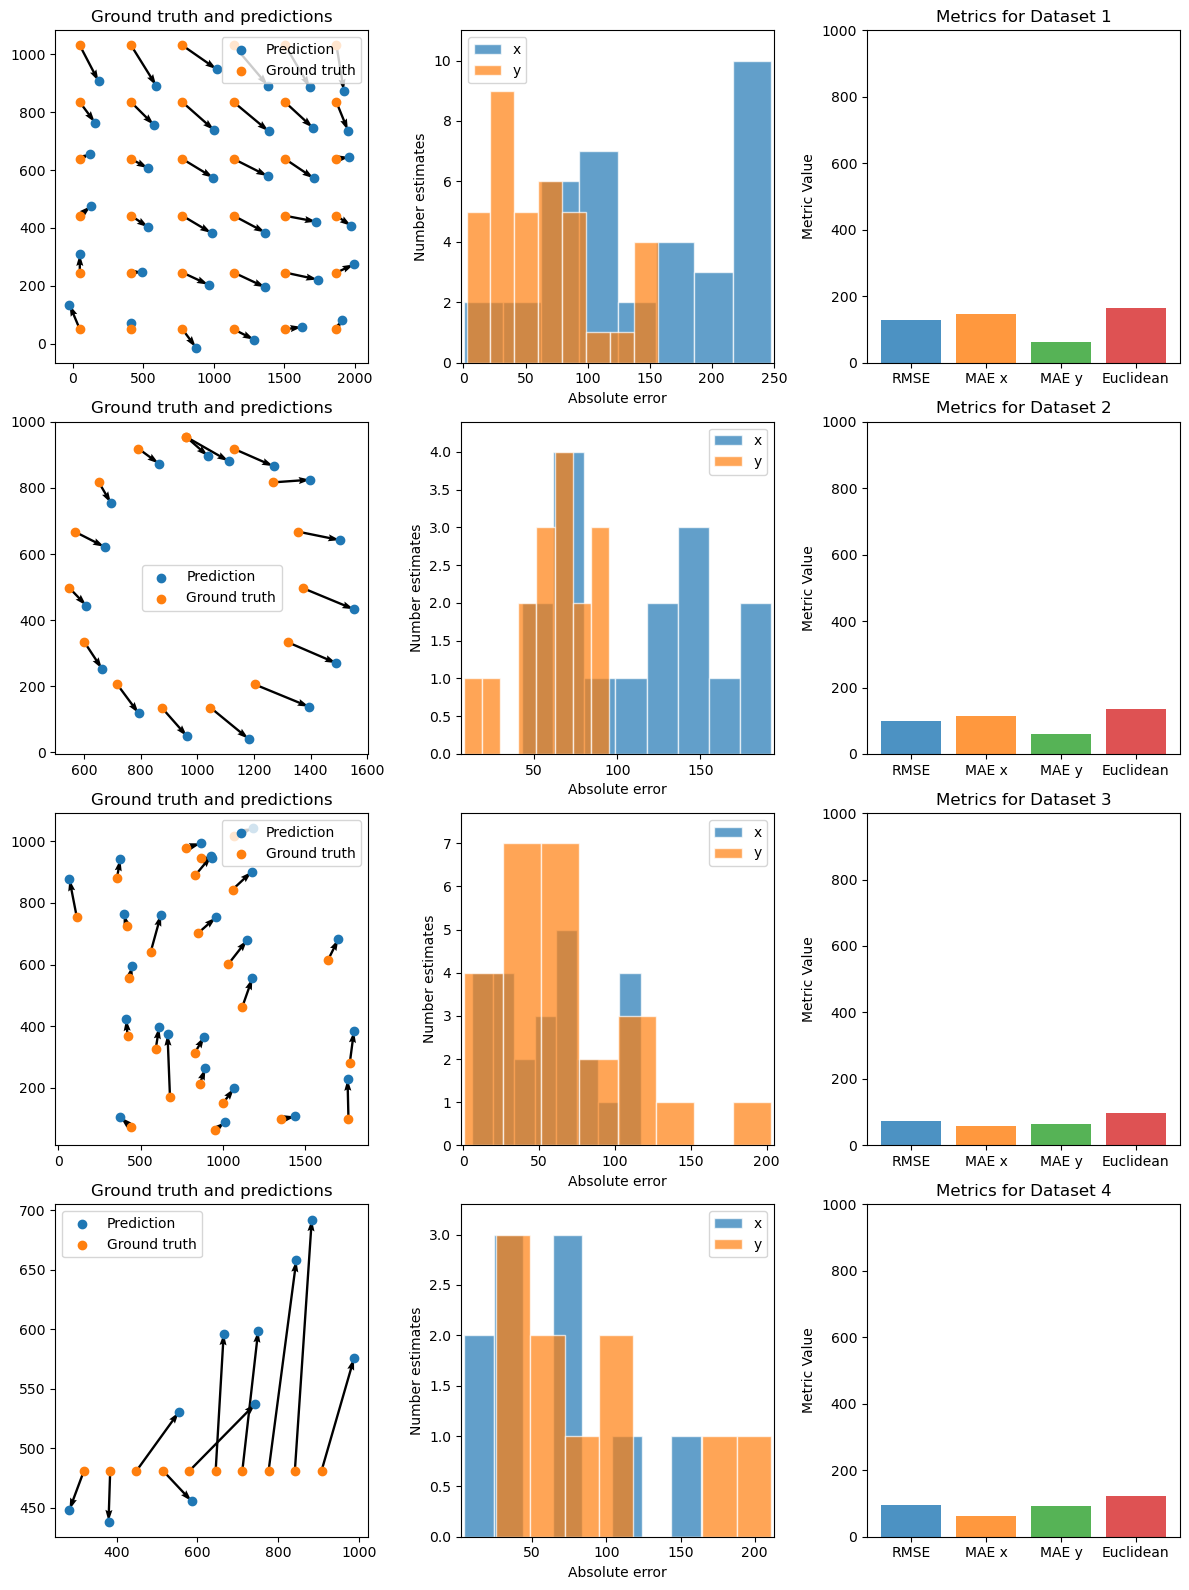

In [29]:
iml_util.plot_results_grid(results_linear, 4)

<article class="message task"><a class="anchor" id="evaluation1"></a>
    <div class="message-header">
        <span>Task 6: Evaluate performance of your model</span>
        <span class="has-text-right">
          <i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Evaluate the usefulness of the _mae_ or _rmse_ and their differences.
2. Identify at least 3 potential sources of error associated with the current affine model. Describe how each source of error contributes to the prediction error.



</div></article>



In [30]:
#Write your reflection here...
'''
    1. The usefulness of MAE x and MAE y describe the precision of the performance of our model.
       MAE x describes how wrong/corrent the X coordinates were and MAE y describes the Y coordinates.

       The RMSE describes the precision of the performance of our model, combining (x, y) coordinates. Since RMSE squares the error values,
       bigger errors will fluctuate the resulting value much more than smaller values. This means that RMSE might be smart to look at if you
       are primarily concerned with your more severe outliers, and lesser so if you are more concerned with smaller errors.

       The numbers therefore provide an insight to whether or not the model scores well on the X coordinates and/or the Y coordinates.

       For example, we can see in the first model, where the subject had to track points in a circle, we can see that the
       predicted y coordinates were close to the actual y coordinates, while the x coordinates differ more.

    2. - Some of the models have fewer datapoints to make the predictions on and this can lead to worse results
          (ex. the last one compared to the first one)
       - The preprocessing of data might go wrong. For instance we can see, that the preprocessing of the data from the last model has gone wrong,
       as we can see by inspecting the pictures, that the person in following a straight line, but the collected data is predicted to be
       more randomly. This leads to worse results-
       - The Fovea is not directly aligned with the center of the pupil, but at a person-specific angle.

'''

'\n    1. The usefulness of MAE x and MAE y describe the precision of the performance of our model.\n       MAE x describes how wrong/corrent the X coordinates were and MAE y describes the Y coordinates.\n\n       The RMSE describes the precision of the performance of our model, combining (x, y) coordinates. Since RMSE squares the error values,\n       bigger errors will fluctuate the resulting value much more than smaller values. This means that RMSE might be smart to look at if you\n       are primarily concerned with your more severe outliers, and lesser so if you are more concerned with smaller errors.\n\n       The numbers therefore provide an insight to whether or not the model scores well on the X coordinates and/or the Y coordinates.\n\n       For example, we can see in the first model, where the subject had to track points in a circle, we can see that the\n       predicted y coordinates were close to the actual y coordinates, while the x coordinates differ more.\n\n    2. - So

You have now went through the first part of the assignment processing the session of `test_subject_0`
. The remaining part of the assignment use the same approach as you have just gone through with the purpose of you working with and reflecting on the use of your own data collected. 
## Test on test subject 3
In the data processing exercise Data preprocessing
 the pupil corrdinates `mean_pupil_coordinates.csv`
 and the corresponding screen coordinates `screen_coordinates.csv`
 were saved in the in the folder with the test subjects and patterns. Recall the four calibration patterns used for the data collection being **grid**, **circle**, **line** and **random**.
In this exercise you will use the calibration (training data) of `test_subject_0`
 on the data from `test_subject_3`
 and visualized in [Figure 4](#calibration).
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="calibration">

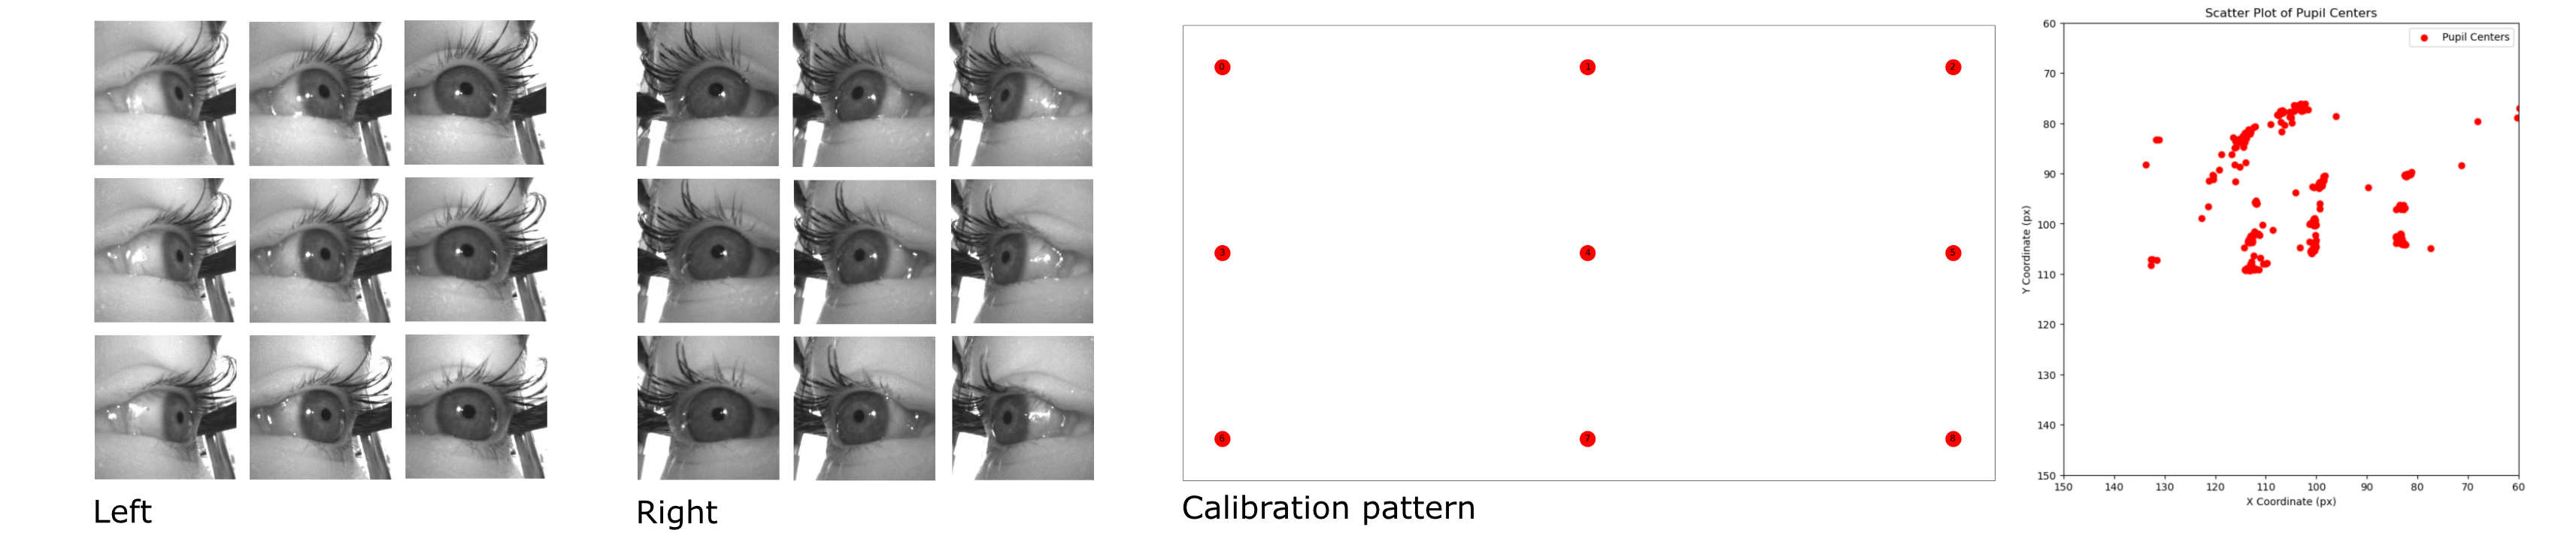

<figcaption class="figure-caption has-text-centered">Figure 4: Left: Images fron calibration pattern grid. Middle: Calibration pattern. Right: Pupil center scatterplot from calibration pattern grid.</figcaption>
</figure>
</div>


</div>

<article class="message task"><a class="anchor" id="ts31"></a>
    <div class="message-header">
        <span>Task 7: Load the data</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Run the cell below to load the data of `test_subject_3`
. _Similarily_ to the data of `test_subject_0`
 meaning that the `grid`
 pattern is defined as training set for all other patterns. The data is stored as a list of dictionaries in the following order: `grid`
, `circle`
, `line`
, and `random`
. Within each dictionary you find: 

<article class="message is-primary">
  <div class="message-header">Details about the data format of `test_subject_3`</div>
  <div class="message-body">
  
  **Dataset elements:**
- `pupils_train`
: Mean pupil positions for the 9 calibration points from `grid`
 pattern (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the 9 calibration points from `grid`
pattern ($9 \times 2$ array containing x,y pixel position for the target on the screen (`sx`
, `sy`
)).
- `pupils_test`
: Mean pupil positions for the calibration points for the pattern accociated as the key(an $N \times 2$ array containing the $N$ x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the N calibration points associated to the pattern defined as the key ($N \times 2$ array containing the $N$ x andy pixel positions for the target on the screen (`sx`
, `sy`
))


  
  </div>
</article>



</div></article>



In [31]:
D3 = iml_util.gen_data_subject('test_subject_3')

<article class="message task"><a class="anchor" id="ts31"></a>
    <div class="message-header">
        <span>Task 8: Visualize performance</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Run the cell below to evaluate the gaze estimation model using the data from `test_subject_3`




</div></article>



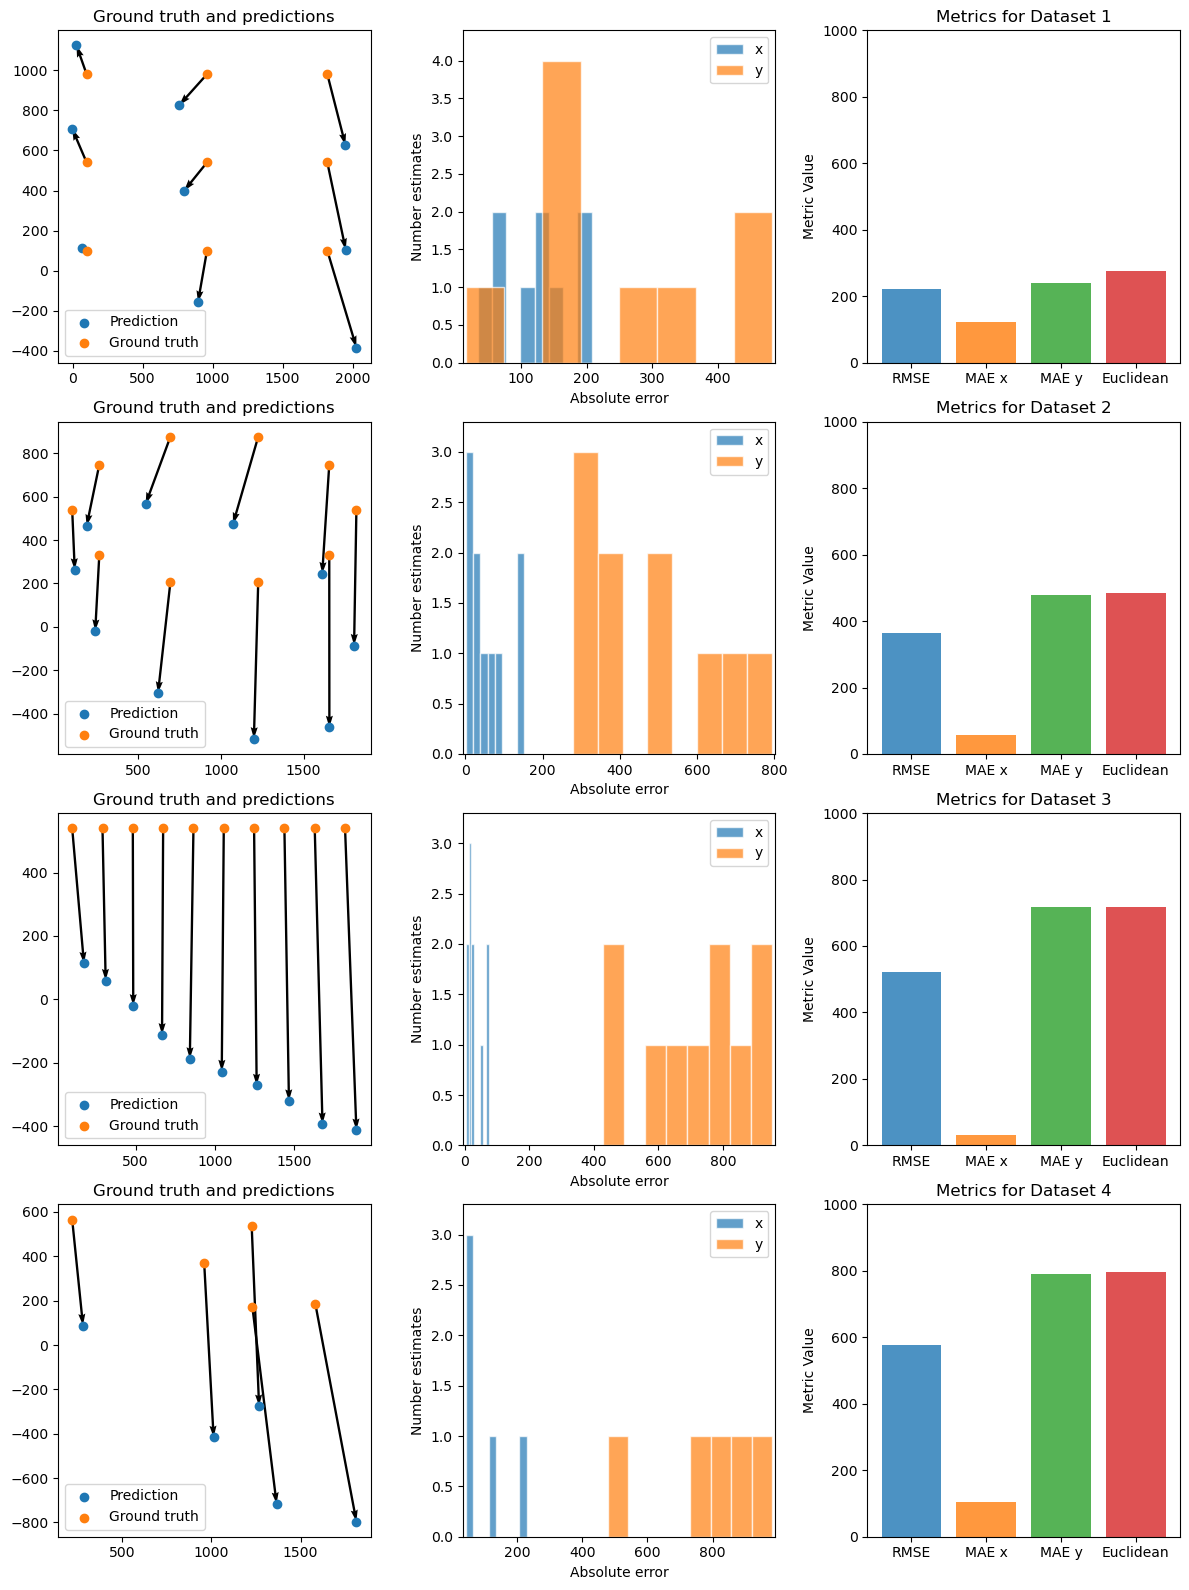

In [32]:
results_linear_ts3 = results_for_model(LinearGaze(), D, D3, 'pupils_n_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_ts3, 4)

<article class="message task"><a class="anchor" id="task_model"></a>
    <div class="message-header">
        <span>Task 9: Evaluation</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


You likely have observed larger prediction errors, including the `MAE_y`
 and `RMSE`
. Reflect on:
1. How well does the model predict gaze of `test_subject_3`
?
2. Use your reflections in Task 8 in the exercise Data preprocessing
 to elaborate on the results in this exercise.
3. Comment on differences between the predicted `x`
 and `y`
 coordinate.



</div></article>



In [33]:
#Write your reflections here...
"""
    1. The X-coordinate is very precise, whereas the Y-coordinate is far off. This is an inadequate prediction
    model for gaze.

    2. The awkward sitting height, and the non-adjustable setting of the chin-rest, can very well have had an
    impact on each subject's ability to direct their gaze in a natural way. This might be a factor in the very
    imprecise predictions on the Y-coordinate. Further, the fact the the test subjects were not properly
    "fastened" to the chin-rest made it possible to move the entire head when shifting gaze. It is less
    comfortable to adjust gaze vertically than horizontally, so this might also have muddied the readings.

    3. The oblong shape of the human eye might make it easier to see differences on the X-axis than on the
    Y-axis. There is more room for movement.

"""

'\n    1. The X-coordinate is very precise, whereas the Y-coordinate is far off. This is an inadequate prediction\n    model for gaze.\n\n    2. The awkward sitting height, and the non-adjustable setting of the chin-rest, can very well have had an\n    impact on each subject\'s ability to direct their gaze in a natural way. This might be a factor in the very\n    imprecise predictions on the Y-coordinate. Further, the fact the the test subjects were not properly\n    "fastened" to the chin-rest made it possible to move the entire head when shifting gaze. It is less\n    comfortable to adjust gaze vertically than horizontally, so this might also have muddied the readings.\n\n    3. The oblong shape of the human eye might make it easier to see differences on the X-axis than on the\n    Y-axis. There is more room for movement.\n\n'

## Gaze estimation test subject 3
In this the gaze estimation model is trained using the `grid`
 pattern of `test_subject_3`
, and test it on the patterns. 
<article class="message task"><a class="anchor" id="ts311"></a>
    <div class="message-header">
        <span>Task 10: Train and test a model</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Use `result_for_model`
 to train and test a gaze estimation model based on `test_subject_3`
.
2. Use `plot_results_grid`
 to visualize the result.

**Note:** The result using pupil centers from the `grid`
 pattern is a result of training and testing on the same data.



</div></article>



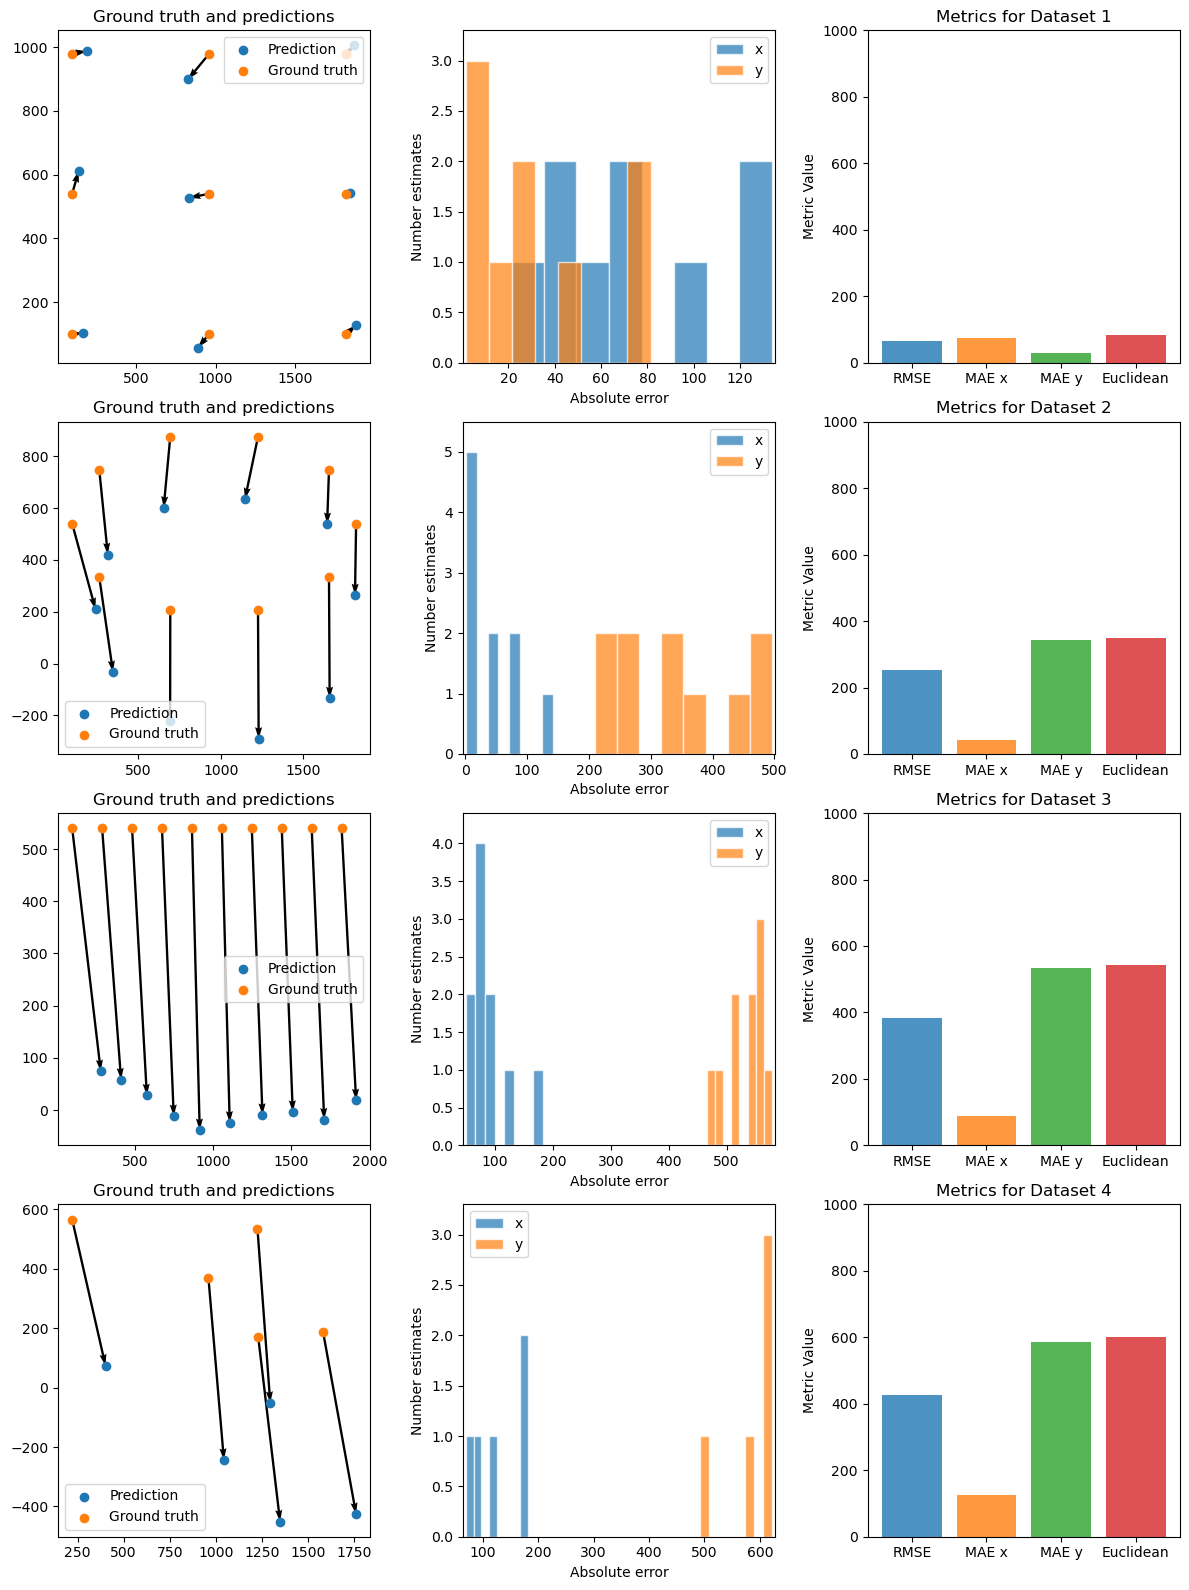

In [34]:
# Write your code here
results_linear_d3 = results_for_model(LinearGaze(), D3, D3, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_d3, 4)

<article class="message task"><a class="anchor" id="ts312"></a>
    <div class="message-header">
        <span>Task 11: Evaluation</span>
        <span class="has-text-right">
          <i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Reflect on the result testing the model on `test_subject_3`
.     - Use your reflection from Task 8 in exercise Data preprocessing
 to elaborate on the result.        - Why does the performance of the model trained on `test_subject_3`
 show significantly larger prediction errors compared to the one trained **and** tested on `test_subject_0`
?







</div></article>



In [35]:
#Write your reflections here...
'''
    D0 has 3-4x as many points as D3 to train the model, making it a stronger data-set my sheer size.
    A small set runs the risk of severe imprecision when generating the model, and that is what we are seeing here.
'''

'\n    D0 has 3-4x as many points as D3 to train the model, making it a stronger data-set my sheer size.\n    A small set runs the risk of severe imprecision when generating the model, and that is what we are seeing here.\n'

You may by now you have observed that the model is struggling with properly predicting the `y`
 coordinates. The cell below visualizes the model predictions separating the `x`
 and `y`
 coordinate.
<article class="message task"><a class="anchor" id="ts313"></a>
    <div class="message-header">
        <span>Task 12: Evaluation(continued)</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Run the cell below to viualize the models independently. 
2. Use the plot for further evaluation, reflect on the questions:    - Observe that the model are struggling the most in predicting the `y`
 coordinate correctly. What is a possible explanation for this? 
    - What would happen to the plane if we train the model on more data points?



**Note:** Incoorporate your reflections from exercise Data preprocessing
 Task 8.



</div></article>



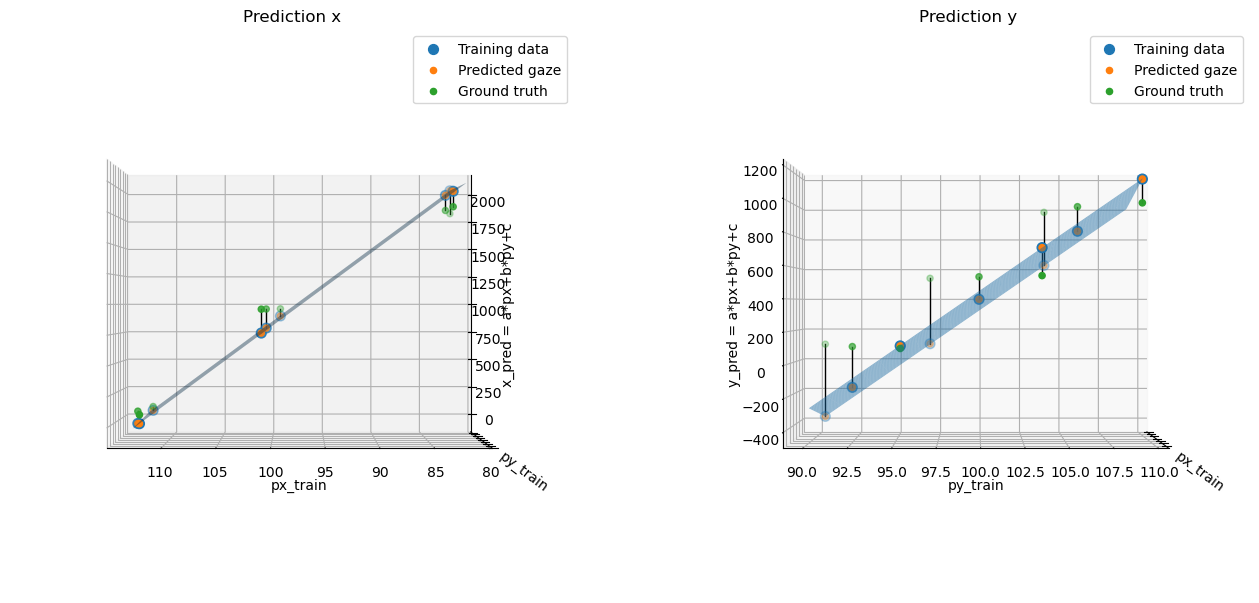

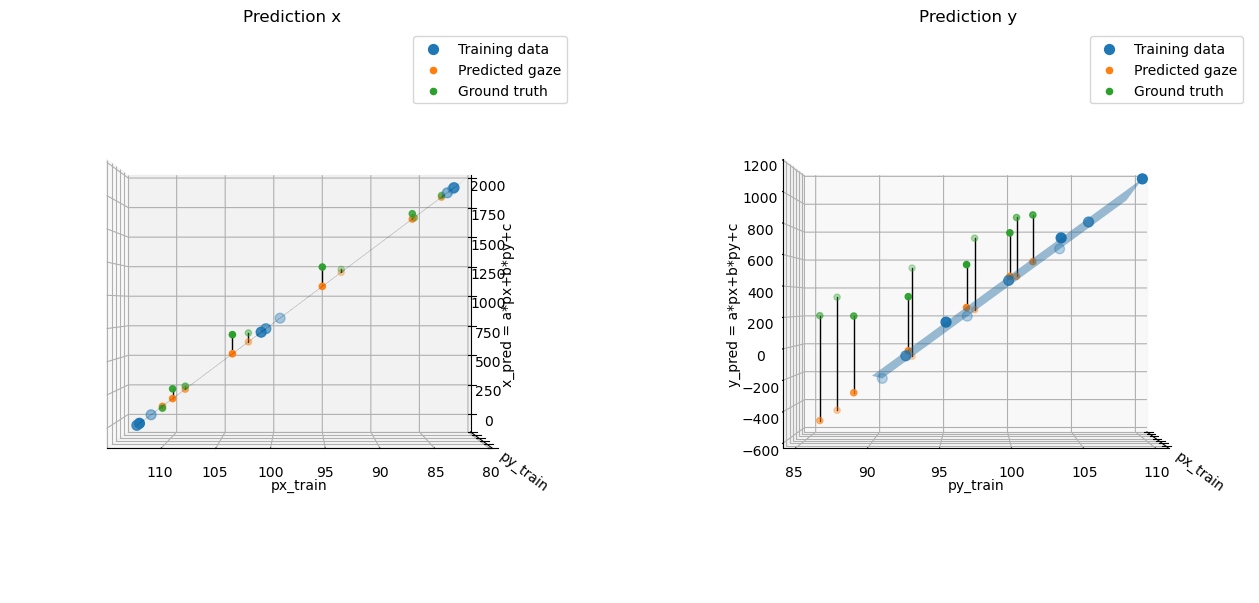

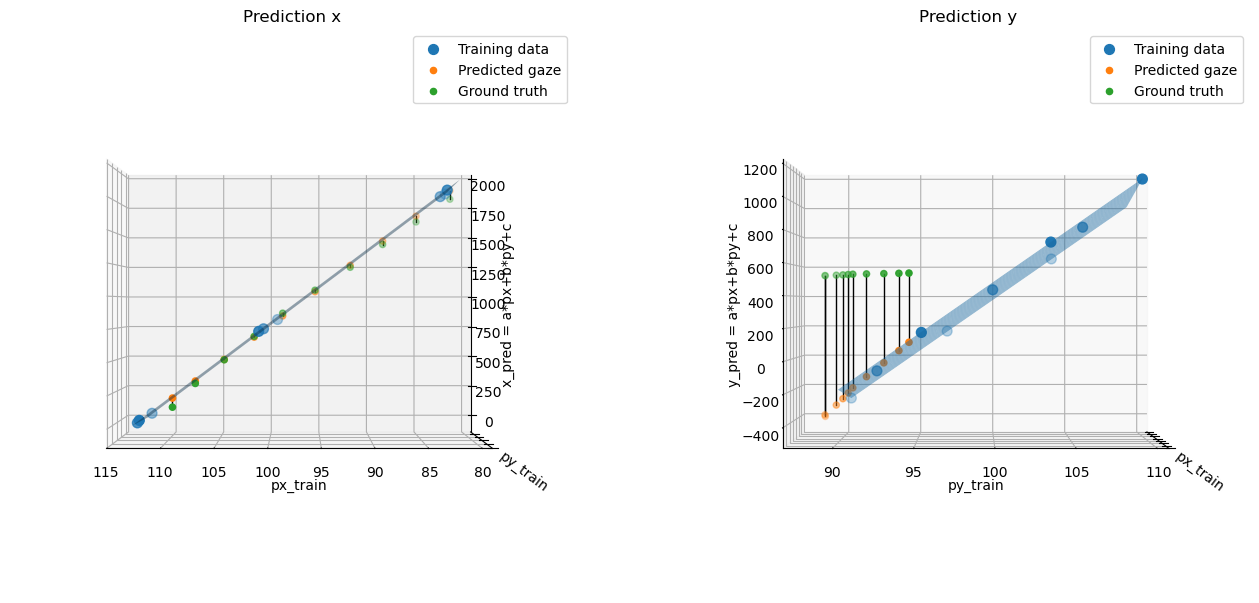

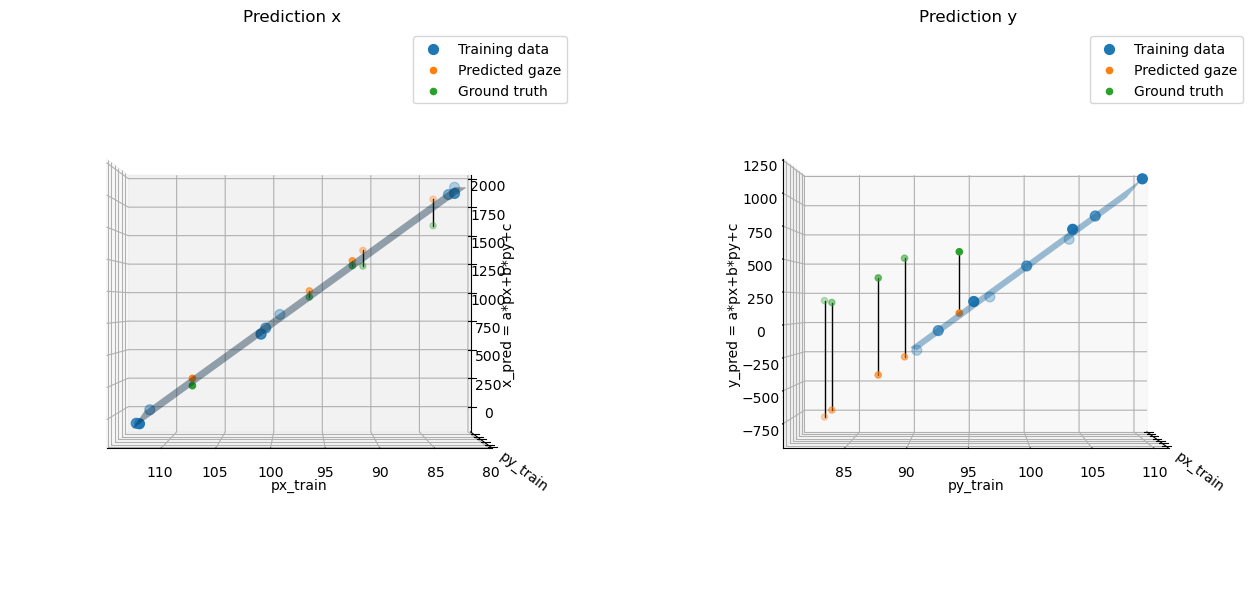

In [56]:
for i in range(len(results_linear_ts3)):
    iml_util.plot_from_results_dict(results_linear_ts3[i], D3[i])



To further elaborate on the prediction of the `y`
coordinate, the cell below visualizes the  _Sum of Squared Error_ (SSE) loss function, in parameter space. 
The cell below creates two plots, left is the loss when changing parameters `a`
 and `b`
 while keeping  `c`
 fixed. The right plot shows loss when varying `c`
 while keeping `a`
 and `b`
 fixed.
<article class="message task"><a class="anchor" id="ts314"></a>
    <div class="message-header">
        <span>Task 13: Evaluation(continued)</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. Run the cell below to visualize the loss described by the parameters. 
2. Describe the effect each parameter has on the SSE.



</div></article>



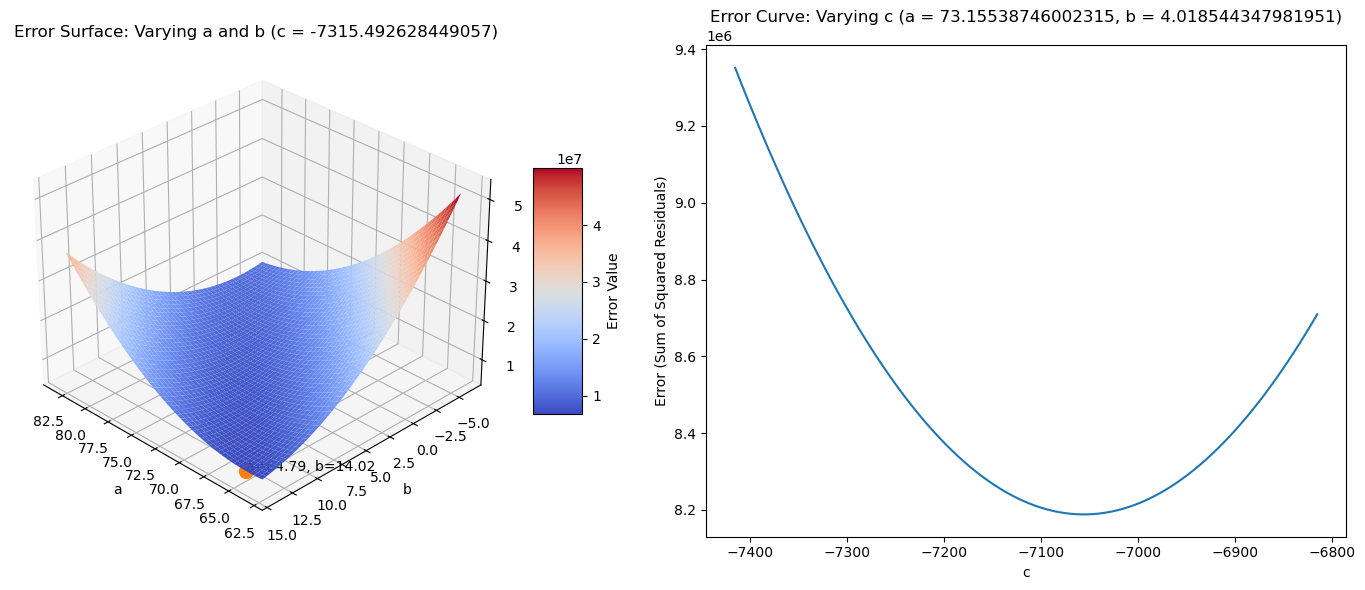

In [37]:
# Example usage with sample data
x = D3[0]['pupils_train'][:,0]
y = D3[0]['pupils_train'][:,1]
z = D3[0]['screen_coordinates_train'][:,1]  # Actual targets

# Set fixed values for a, b, and c (based on an example linear model)
a_fixed = results_linear_ts3[0]['model_y'][2]
b_fixed = results_linear_ts3[0]['model_y'][1]
c_fixed = results_linear_ts3[0]['model_y'][0]

# Plot the error surfaces
iml_util.plot_error_surfaces(a_fixed, b_fixed, c_fixed, x, y, z)

In [38]:
#Write your reflections here...
# TODO: do this

<article class="message task"><a class="anchor" id="ts315"></a>
    <div class="message-header">
        <span>Task 14: Evaluation(continued)</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights hard"></i>
        </span>
    </div>
<div class="message-body">


1. Observe that it appears as the prediction could benefit from a different value of `c`
 than the least square model has learned. Reflect on why this occurs.    - Why might adjusting the slope be more important for reducing the overall error?
    - How might this affect the optimization of $c$ compared to $a$ and $b$ when there is a large scale difference between inputs and labels?



**Note:** Hint: The model minimizes the total error by adjusting the parameters. Changing `a`
 and `b`
 affects how well the slope fits the data trend, while `c`
 just shifts the plane. 
The model tries to minimize the sum of squared errors $\sum \left( z - (ax + by + c) \right)^2$. If $x$ and $y$ are much smaller in scale than $z$, the terms $a \cdot x$ and $b \cdot y$ contribute less to the error than $c$.



</div></article>



In [39]:
#Write your reflections here...

Until now the models have been trained using the nine calibration points from the `grid`
 pattern. You will now increase the amount of training data by incoorporating all patterns except `circle`
. The pattern `circle`
 will be used for testing. In the cell below a dictionary `D3_mod`
 contains the training and test data similar to the structure of `D`
and `D3`
. . 
<article class="message task"><a class="anchor" id="task_model_evaluate1"></a>
    <div class="message-header">
        <span>Task 15: Adding more data</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Use the function`results_for_model`
 and the `LinearGaze`
 class to train a new model using `D3_mod`
. Use `plot_results_grid`
 to visualize the results and the function `plot_from_results_dict`
 to visualize the models.
2. Run the cell below to train and test the model and visualize the result. 



</div></article>



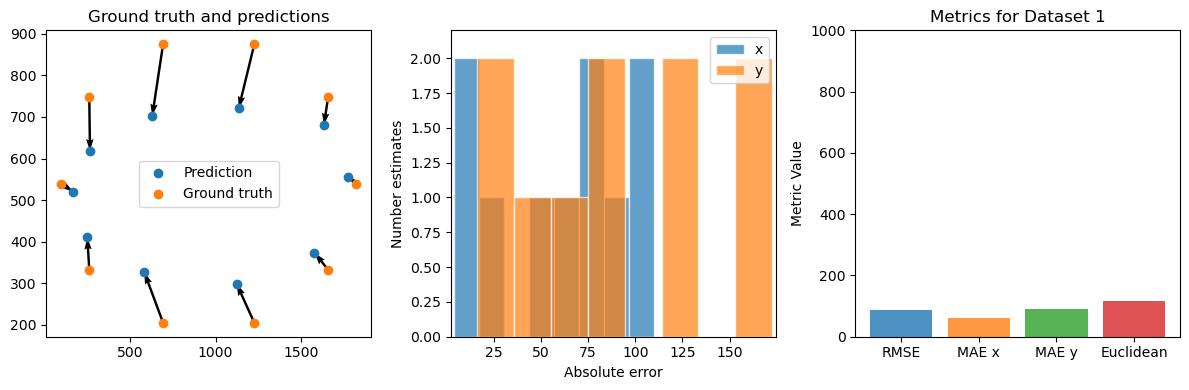

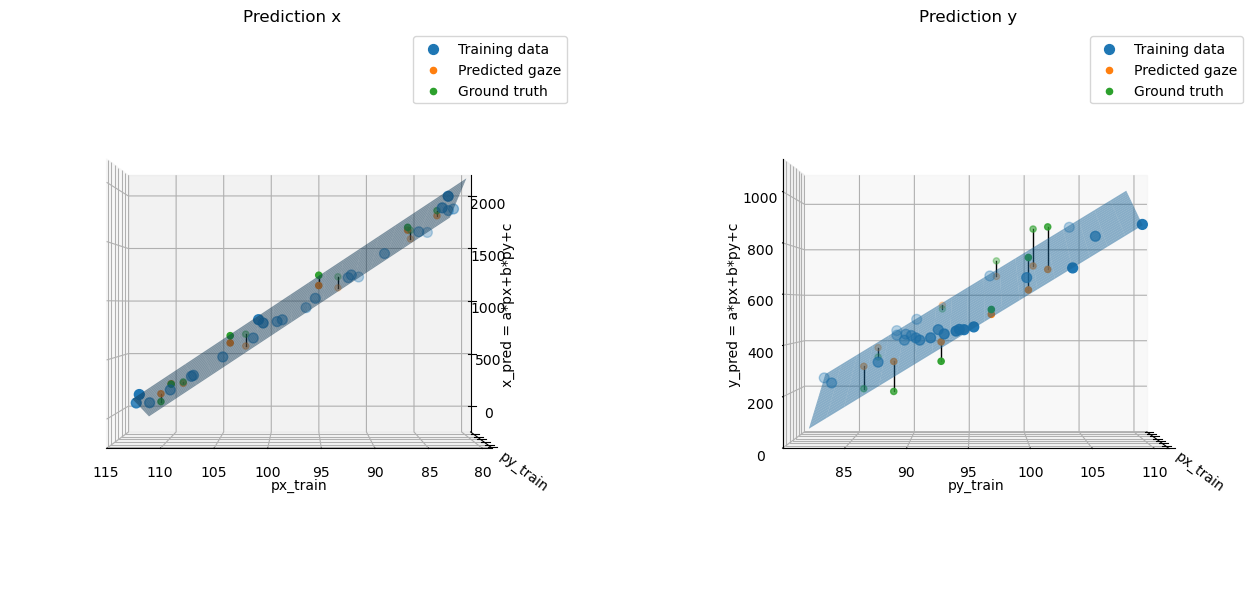

In [55]:
D3_mod = {}

ts3_p_train = D3[0]['pupils_test']
ts3_s_train = D3[0]['screen_coordinates_test']

ts3_p_test = D3[1]['pupils_test']
ts3_s_test = D3[1]['screen_coordinates_test']

for i in range(2,4):
    ts3_p_train = np.vstack((ts3_p_train,D3[i]['pupils_test']))
    ts3_s_train = np.vstack((ts3_s_train,D3[i]['screen_coordinates_test']))

D3_mod['pupils_train'] = ts3_p_train
D3_mod['screen_coordinates_train'] = ts3_s_train
D3_mod['pupils_test'] = ts3_p_test
D3_mod['screen_coordinates_test'] = ts3_s_test

D3_mod = [D3_mod]

# Write your code here
results_linear_d3_mod = results_for_model(LinearGaze(), D3_mod, D3_mod, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 1)

iml_util.plot_results_grid(results_linear_d3_mod, 1)


for i in range(len(results_linear_d3_mod)):
    iml_util.plot_from_results_dict(results_linear_d3_mod[i], D3_mod[i])

<article class="message task"><a class="anchor" id="task_model_evaluate133"></a>
    <div class="message-header">
        <span>Task 16: Evaluate</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. How does adding more training data affect the results.    - Does increasing the amount of training data _always_ improve the model's accuracy?
    - How does the variability in the data affect the model's ability to generalize when more data is added (elaborate on your reflection from Task 2.3)?
    - How could adding more data influence the optimization of the model parameters?





</div></article>



In [41]:
#Write your reflections here...
'''
Adding more training data will force the model to try to accommodate more points: the graph will minimize its
overall distance to each point. It is rarely possible to match all points well, and depending on the training data, this might be impossible.

Adding more training data will not always improve the model's accuracy, that all depends on the quality, accuracy,
and balance of the data. For example, if 99% of the data is focused on movement along the x-axis, predictions in this area might be very good, while predictions on the y-axis would be terrible
'''

"\nAdding more training data will force the model to try to accommodate more points: the graph will minimize its\noverall distance to each point. It is rarely possible to match all points well, and depending on the training data, this might be impossible.\n\nAdding more training data will not always improve the model's accuracy, that all depends on the quality, accuracy,\nand balance of the data. For example, if 99% of the data is focused on movement along the x-axis, predictions in this area might be very good, while predictions on the y-axis would be terrible\n"

## Individual dataset
The pipeline of collecting data, training a model, testing, and evaluating it has been introduced. In this task, the data of your eyes will be used to train a model. Use the evaluation tools introduced in the assignment.
**Note:** **Important!** In case you do **not** want to share your data with the TA's for assessment, train and evaluate the models using your data and place images of the evaluation in the folder `data/output/individual`
. Comment out the coding cells for this part of the assigment for handin to allow TA's to run the entire notebook without errors, c.f. submitting details on [About the course](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)
. Submit the assignment without the data folder containing your data, and refer to evaluation images by name in your reflections.

<article class="message task"><a class="anchor" id="task_model_evaluate3"></a>
    <div class="message-header">
        <span>Task 17: Individual dataset</span>
        <span class="has-text-right">
          <i class="bi bi-stoplights easy"></i>
        </span>
    </div>
<div class="message-body">


1. For reproduceability, write the _threshold_, _x_margin_, _y_margin_ and _side_ values that was used in the processing your data in Task 4 of the  Data preprocessing
 exercise.



</div></article>



In [42]:
#Note the values here
Threshold = 36
x_margin = 40
y_margin = 30
side = 'left'


<article class="message task"><a class="anchor" id="task_model_evaluate2"></a>
    <div class="message-header">
        <span>Task 18: Train and test a model</span>
        <span class="has-text-right">
          <i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Run the cell below to generate a dictionary of your own data.
2. Train an affine gaze estimation model using the pattern `grid`
.
3. Test the model on  all patterns.



</div></article>



In [43]:
# update the parameter and uncomment the line below
rakt = iml_util.gen_data_subject('group-12-rakt')
ssbo = iml_util.gen_data_subject('group-12-ssbo')

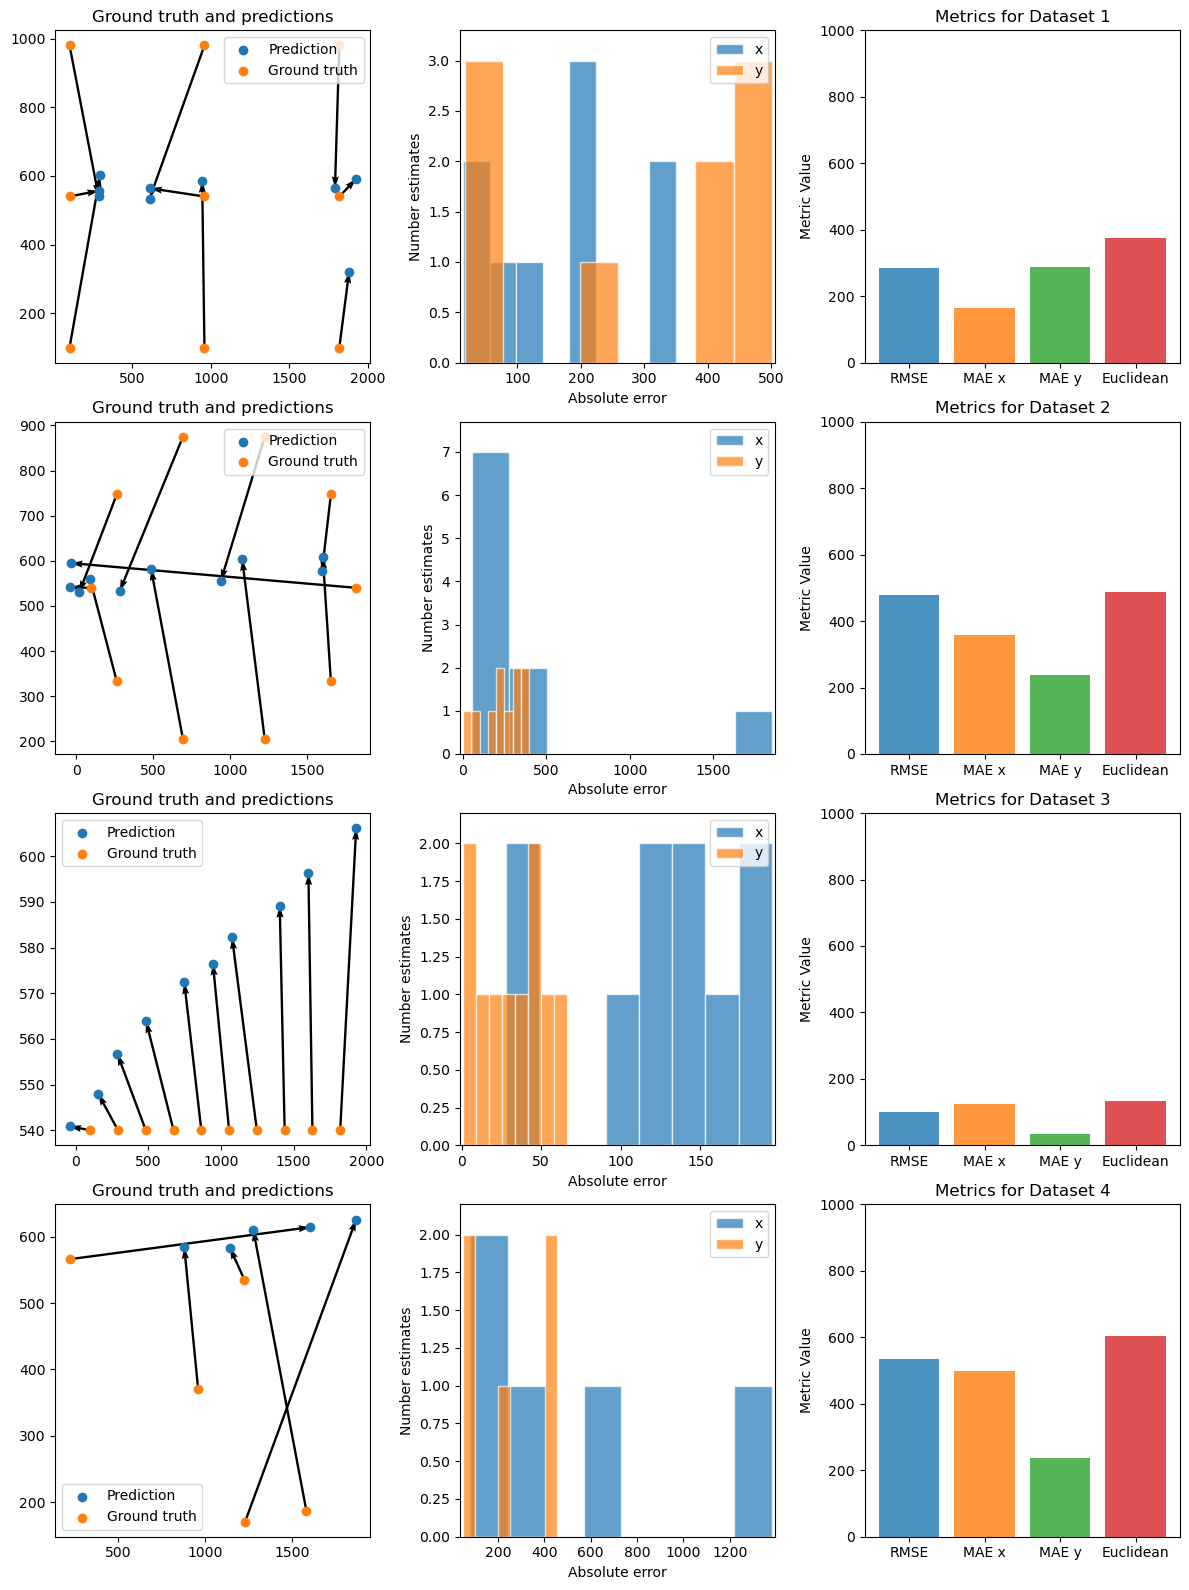

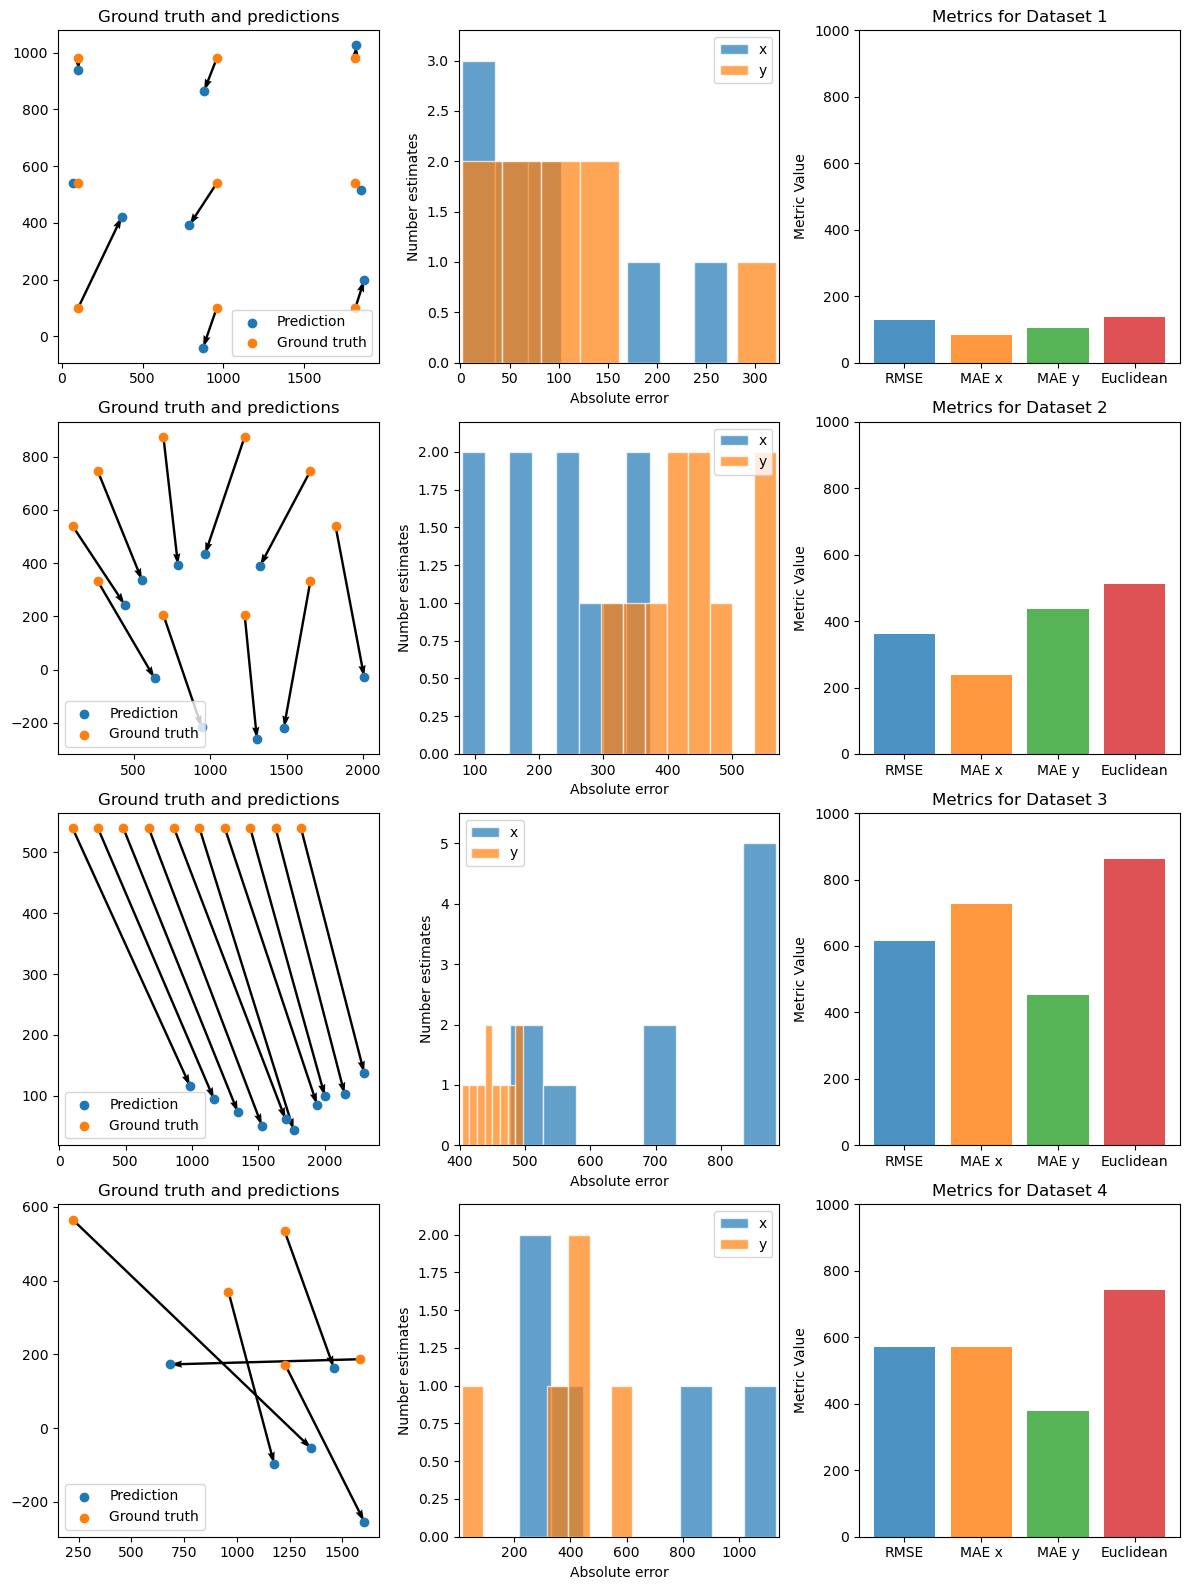

In [44]:
#Use this cell to train and evaluate your model...
results_linear_rakt = results_for_model(LinearGaze(), rakt, rakt, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_rakt, 4)

results_linear_ssbo = results_for_model(LinearGaze(), ssbo, ssbo, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_ssbo, 4)

<article class="message task"><a class="anchor" id="task_model_evaluate2"></a>
    <div class="message-header">
        <span>Task 19: Evaluate</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. As in previous tasks, reflect on the results.



</div></article>



In [45]:
# Write your reflections here...
'''
To complete this task, we had to complete the steps from task 7 in the 01-data-preprocessing exercise set.
Here we generated scatter-plots for both grid, line, circle, and random, and inspected these plots to
ascertain the mean coordinates in the training- and test data for each screen-coordinate.
This of course is not perfectly accurate, but for the purposes of the exercise it was deemed sufficient.
'''

'\nTo complete this task, we had to complete the steps from task 7 in the 01-data-preprocessing exercise set.\nHere we generated scatter-plots for both grid, line, circle, and random, and inspected these plots to\nascertain the mean coordinates in the training- and test data for each screen-coordinate.\nThis of course is not perfectly accurate, but for the purposes of the exercise it was deemed sufficient.\n'

# Optional improvements
You may experience that the models behave differently on your dataset than on `test_subject_0`
 and `test_subject_3`
. This can be due to several factors, some of which you may have already reflected on in Task 8 in exercise Data preprocessing
. If you experience interesting behaviour in the predictions of your model you are of course welcome to explore it further such as:
- Different combinations of training set (use can use the creation of `D3_mod`
 for inspiration as to how to manipulate the combination of data for training and testing).     - If you have multiple data sets in your group, you can incoorporate those or use the ones provided, `test_subject_3`
 or `test_subject_1`
. 


- Other evaluation metrics
- Take inspiration from the optional exercises below, to explore your dataset further.

<article class="message task"><a class="anchor" id="task_model_evaluate1"></a>
    <div class="message-header">
        <span>Task 20: Explore your dataset</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Investigate your results and explore options for improving predictions and evaluation.



</div></article>

## Scale the data
In this task, you will improve the model using normalization. In Task 13, you reflected on the effect of having a large scale difference between input and output. Use the data of `test_subject_3`
 in dictionary `D3`
. 
<article class="message task"><a class="anchor" id="task_model_evaluate1"></a>
    <div class="message-header">
        <span>Task 21: Scale the data</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Complete the functions `normalize`
 and `denormalize`
. 
2. Train and test a model using normalized data from `test_subject_3`
. (Note that for the _grid_ pattern you are using the same data for testing and training).
3. Visualize the results using the function `plot_results_grid`
. 



</div></article>



In [46]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data_set):
    """
    Normalizes the pupil and screen coordinate data in the dataset using MinMaxScaler.
    Parameters:
        data_set (list of dict): A list of dictionaries where each dictionary contains training and testing data
                                 for pupils and screen coordinates. Keys include:
                                 - 'pupils_train': N x 2 array of pupil coordinates for training.
                                 - 'screen_coordinates_train': N x 2 array of screen coordinates for training.
                                 - 'pupils_test': N x 2 array of pupil coordinates for testing.
                                 - 'screen_coordinates_test': N x 2 array of screen coordinates for testing.
    Returns:
        d (list of dict): A list of dictionaries with normalized pupil and screen coordinate data.
                          Keys include:
                          - 'pupils_train': Normalized N x 2 array of pupil coordinates for training.
                          - 'screen_coordinates_train': Normalized N x 2 array of screen coordinates for training.
                          - 'pupils_test': Normalized N x 2 array of pupil coordinates for testing.
                          - 'screen_coordinates_test': Normalized N x 2 array of screen coordinates for testing.
        scaler (MinMaxScaler object): The fitted MinMaxScaler object used for normalization.
    """
    scaler = MinMaxScaler()
    # Write your code here

def denormalize(dataset, scaler):
    """
    Denormalizes predicted and ground truth coordinates and calculates errors and performance metrics.
    Parameters:
        dataset (list of dict): A list of dictionaries where each dictionary contains prediction results.
                                Keys include:
                                - 'predicted': N x 2 array of normalized predicted coordinates.
                                - 'ground_truth': N x 2 array of normalized ground truth coordinates.
        scaler (MinMaxScaler object): The MinMaxScaler object used for normalization, applied here to inverse-transform data.
    Returns:
        d (dict): A dictionary where each key corresponds to a dataset index, and each value contains the following:
                  - 'predicted': Denormalized N x 2 array of predicted coordinates.
                  - 'ground_truth': Denormalized N x 2 array of ground truth coordinates.
                  - 'errors': N x 2 array of absolute errors between predicted and ground truth coordinates.
                  - 'mse' (1 x 2 numpy array): Mean squared error for the x and y coordinates.
                  - 'rmse' (float): Root mean squared error (RMSE) across the dataset.
                  - 'dist' (float): Mean Euclidean distance between predicted and ground truth positions.
                  - 'mae' (1 x 2 numpy array): Mean absolute error for the x and y coordinates.
    """
    # Write your code here


# Write your code here for training, testing and visualizing results

<article class="message task"><a class="anchor" id="task_model_evaluate22"></a>
    <div class="message-header">
        <span>Task 22: Evaluation</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Evaluate the results based on the plots and compare to the results from Task 11.
2. What possible pitfalls could there be in normalizing the data?
3. The pattern _line_ though improved, occurs to perform the worst, use your previous reflection from Task 8 in exercise Data preprocessing
 to reflect on why.



</div></article>



In [47]:
#Write your reflections here...

## Improve the model
This final part of the exercise requires you to modify  the gaze model $f_{\mathbf{w}}(x,y)$ into a quadratic model. As in [Task 5](#task_model), you will create a model for each output coordinate, i.e. $x', y'$. 
**Note:** In this step you create one model for each output coordinate seperately but it is possible to create a single model that simultaneously maps the $x'$- and $y'$-coordinates. However, we leave it as an optional exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices.

Since the model is two-dimensional, the quadratic polynomial has  more model parameters than for one dimension model. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$
The design matrices then have the following form:
<article class="message task"><a class="anchor" id="improvements"></a>
    <div class="message-header">
        <span>Task 23: Model improvements</span>
        <span class="has-text-right">
          <i class="bi bi-code"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. **Design matrix:** 
Argue why the desginmatrix for each output coordinate of the gaze mapping function is given by 

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.$$


2. **Implement model:** Implement the 2. order model and train it (calibrate) on each dataset.

3. **Evaluate:** Repeat the evaluation steps you did for the linear model above in [Task 2](#evaluation) (subtask 1-2). Additionally:
    - Create a barplot of the _rmse_ of both models for each dataset. Use the `bar_comparison_plot`
 function. 


4. **Compare with linear results:**
    - Is there a significant difference between the _rmse_'s of the linear and 2. order models? Explain why either is the case. Use your previous discussion of model limitations and error sources in your explanation.
    - Compare the scatter plots for the predictions vs. ground-truth for both models. Is there a qualitative difference in performance in some instances? Explain why either model performs better in particular cases and relate your answer to the previous question.





</div></article>



In [48]:
def get_design_matrix_quad(pupil_positions):
    # Write your implementation

def quad(param, x):
    return param[0] + param[1]*x[0] + param[2]*x[1] + param[3]*x[0]*x[1] + param[4]*x[0]**2 + param[5]*x[1]**2

class QuadGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the LinearGaze model by fitting two linear regression models for x and y coordinates based
        on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data with two keys:
                - "pupils_train" (N x 2 numpy array): n samples, 2 features (px, py) representing pupil
                  positions.
                - "positions_train" (N x 2 numpy array): n samples, 2 features (screen coordinate x, screen coordinates y) representing
                  the true gaze positions being the screen coordinates.

        Returns:
            None: Updates the model's parameters (self.model_x, self.model_y) based on
            the least squares solution for x and y positions.
        """
        # Write your implementation


    def predict(self, pupil):
        # Write your implementation


results_quad = results_for_model(QuadGaze(), D, D, 'pupils_n_train', 'screen_coordinates_train', 'pupils_n_test', 'screen_coordinates_test', 4)




# Write your implementation here

IndentationError: expected an indented block after function definition on line 1 (323339067.py, line 4)

<article class="message task"><a class="anchor" id="task_model_evaluate2"></a>
    <div class="message-header">
        <span>Task 24: Evaluation</span>
        <span class="has-text-right">
          <i class="bi bi-infinity"></i><i class="bi bi-lightbulb-fill"></i><i class="bi bi-stoplights medium"></i>
        </span>
    </div>
<div class="message-body">


1. Reflect on how the higher order model performs compared to the linear model.    - Does it reduce the error more effectively than the linear model?
    - Does it seem to overfit the training data? Why? Why not?
    - When plotting the residuals, do you notice any patterns for the higher-order model that are not present in the linear model?





</div></article>

<article class="message is-warning">
  <div class="message-header">Submission</div>
  <div class="message-body">
  
  For submission details click [here](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)

Use the [learnIt](https://learnit.itu.dk/)
 page for submission of the handin.

  
  </div>
</article>

